## use Case:
    1. Use It in Jupyter:
                
        from path_manager import addpath
        paths = addpath()
        # Use the returned dictionary if needed
        print("Base dir:", paths['BASE_DIR'])

    2. Use in Python Script:
        from path_manager import addpath
        addpath()
        # Then import modules

### below code , To save the plot and see the data distribution values. x_data = x-axis is created from the data values by uniformly distributting the data from min(data) to max(data)
### we can have quick look of data arrangement , but there is drawback in plot that y-values if they are same should be look piled up on each other will look apart by a certain x-axis difference. so we will plot it differently : 

### - this just below code is written in module ( MODULE NAME : plot_dataModule.py) -->
### - here there are two class methods are defined for both plot_Type = 0/1  --> 0 -->  def plot_simple(self, file, save_name=None)  and  1--> plot_complex(self, file, save_name=None).
### -  from plot_dataModule import DataPlotter
    # Example data usage
    plotter = DataPlotter(
        # __init__(self, data_dir, base_dir=None, save_results=True, save_dir=None)
        data_dir="data/raw_npyData",  # relative to BASE_DIR
        base_dir="E:/Projects/substructure_3d_data/Substructure_Different_DataTypes"
    )
    plotter.run_all(complex_plot=True)


In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

BASE_DIR = Path.cwd().parent
print(f"Base directory: {BASE_DIR}")

RES_DIR = BASE_DIR / "results"
print(f"Results directory: {RES_DIR}")

plt.style.use("ggplot")
%matplotlib inline

# from path_manager import addpath
# paths = addpath()

Base directory: c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes
Results directory: c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\results


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import os
import time
# print(f"garbage path : {os.getcwd()} and \n {Path.home()}")
# cws = Path(__file__).resolve().parent   # use it everywhere for current working scripts path (cws)
cws = Path.cwd()
BASE_DIR = cws.parent             # \Projects\substructure_3d_data\Substructure_Different_DataTypes\
DATA_PATH = BASE_DIR /"data"      # \Projects\substructure_3d_data\Substructure_Different_DataTypes\data\
rawnypyData_Path = DATA_PATH/"raw_npyData"
data_dir = str(rawnypyData_Path)
print(f"data_dir : {data_dir}")


save_dir = BASE_DIR/"results"/"rawData_XYPlot"
os.makedirs(save_dir, exist_ok=True)  # Create if missing

plot_Type = int(input("enter value 0/1: for simple:0 Complex :1"))
t_start = time.time()

# plot_data_list = [] # to collcet all data(y and x axis both) each for loop. 

plotON_OFF = input("want plot: on else it will not plot saev Time enter ---> : ")

if plot_Type == 0:

    for file in os.listdir(data_dir):

        if file.endswith('.npy'):
            filename = os.path.join(data_dir, file)
            print(f"filename:{file}")
            data = np.load(filename)
            data = data.flatten()
            # data = data.reshape(-1, 1)
            # created the x_axis with it's min and max values and uniformly distributed between them.
            x_data = np.linspace(data.min(), data.max(), len(data))
            
            # plot_data_list.append((x_data,data,file[:-4])) # this is for collect all x,y and filename to plot further for subplot in next cell.

            if plotON_OFF =='on':
                # plot the data
                plt.figure(figsize=(8, 5))  # Wider aspect ratio
                plt.plot(x_data, data, '.', color='royalblue', markersize=0.4, alpha=0.8)
                plt.title(f"{file[:-4]}", fontsize=14, fontweight='bold')
                plt.xlabel('Linearly Spaced values from Data Itself', fontsize=12, fontweight='bold')
                plt.ylabel('RI Data', fontsize=12, fontweight='bold')

                plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
                plt.xticks(fontsize=10)
                plt.yticks(fontsize=10)
                plt.tight_layout()
            

            # save_dir = BASE_DIR/"results"/"rawData_XYPlot"
            save_path = os.path.join(str(save_dir), f"{file[:-4]}.png")

            if f"{file[:-4]}.png" not in os.listdir(save_dir):
                print(f"saving the file in save_path: {save_path}")
                plt.savefig(save_path, dpi=600)
            else:
                print(f"file is already available in save_path: {save_path}")
            
        plt.show()
        plt.close()

if plot_Type == 1:
    countcomplex = 0
    for file in os.listdir(data_dir):
        if file.endswith('.npy'):
            filename = os.path.join(data_dir, file)
            print(f"processing  file, filename: {file}")
            countcomplex += 1

            # if countcomplex > 5:
            if file[0:10] =='Tomogramma' or file[0:3] == 'AML':
                # print(" i am not skipping when continue is off : only one file is allowed to be plotted")
                print(f"skipping the file: {file} and countcomplex: {countcomplex}")
                continue

            data = np.load(filename).flatten()

            x_data = np.linspace(data.min(), data.max(), len(data))

            # === 1. Find horizontal "flat line" band ===
            # Detect most frequent value range using histogram
            hist_vals, bin_edges = np.histogram(data, bins=10000)
            dominant_bin_index = np.argmax(hist_vals)
            bin_start = bin_edges[dominant_bin_index]
            bin_end = bin_edges[dominant_bin_index + 1]

            flat_band = data[(data >= bin_start) & (data < bin_end)]

            if flat_band.size == 0:
                print("No flat band detected.")

                continue

            flat_min = np.min(flat_band)
            flat_max = np.max(flat_band)
            flat_mean = np.mean(flat_band)

            # === 2. Plot with color-coded data ===
            plt.figure(figsize=(10, 6))
            scatter = plt.scatter(x_data, data, c=data, cmap='viridis', s=0.4)

            # === 3. Draw horizontal lines for flat values ===
            flat_y_vals = [("Min", flat_min, 'red'),
                           ("Mean", flat_mean, 'blue'),
                           ("Max", flat_max, 'black')]
            # used_y = []

            # for label, y_val, color in flat_y_vals:
            #     plt.axhline(y=y_val, color=color, linestyle='--', linewidth=1)

            #     # === 4. Auto offset to avoid text overlap ===
            #     offset = 0
            #     while any(abs((y_val + offset) - y) < 0.002 * (flat_max - flat_min) for y in used_y):
            #         offset += 0.002 * (flat_max - flat_min)
            #     y_text = y_val + offset
            #     used_y.append(y_text)

            #     # Text with position
            #     plt.text(x_data[0], y_text, f'{label}: {y_val:.8f}',
            #              color=color, fontsize=6, verticalalignment='bottom')
            
            used_y = []
            x_text_position = x_data[0] - 0.0002*(x_data[-1] - x_data[0])  # shift right
            

            if file[-5:-4] =='h':
                text_gap = 0.12* max(abs(flat_max - flat_min), 1e-1)  # vertical spacing
            else:
                text_gap = 0.05* max(abs(flat_max - flat_min), 1e-1)  # vertical spacing
                

            for i, (label, y_val, color) in enumerate(flat_y_vals):
                y_text = y_val + i * text_gap  # stagger vertically (fixed gap)
                plt.axhline(y=y_val, color=color, linestyle='--', linewidth=0.6)

                plt.text(x_text_position, y_text, f'{label}: {y_val:.16f}',
                        color=color, fontsize=8,
                        verticalalignment='bottom', horizontalalignment='left',
                        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))


            # === 5. Plot settings ===
            plt.title(f"{file[:-4]}")
            plt.xlabel('Linearly spaced vector from data')
            plt.ylabel('RI Values')
            plt.grid(True)
            cbar = plt.colorbar(scatter)

            cbar.set_label('Intensity')

            # Save the figure
            plt.tight_layout()
            # plt.show() # if we put it here then it will show the plot  and the clear it before saving.

            save_path = os.path.join(save_dir, f"{file[:-4]}_marked.png")
            plt.savefig(save_path, dpi=300)
            print(f"saving the file in save_path: {save_path}")

            # if f"{file[:-4]}_marked.png" not in os.listdir(save_dir):
            #     print(f"saving the file in save_path: {save_path}")
            #     plt.savefig(save_path, dpi=300)
            # else:
            #     print(f"file is already available in save_path: {save_path}")
            # Show the plot
            plt.show()
            plt.close()

t_end = time.time()
print(f"Total Time --------------->: {t_end - t_start}")

In [ ]:


import os

import pandas as pd
import textwrap
from tabulate import tabulate
import matplotlib.pyplot as plt

from path_manager import addpath
path = addpath()
from listspecificfiles import readlistFiles
from preprocessAll import DataPreprocessor

summary = []
datpath  = r"data/raw_npyData"
fpath = readlistFiles(datpath,'.npy').file_with_Path()
count = 0
for file in fpath:
    count +=1
    data = np.load(file)
    # data_original = data.copy()
    # data_zero = data[data > 0]
    for d in range(2,6):
        binwidth  = 10**-d
        DataPreprocessor.histogram_plotWithBinwidthVariation(data, binwidth = binwidth)
        # if data.ndim >= 2:
        #     data = data.flatten()
        # else:
        #   # data.ndim == 1:
        #     data = data
        
        # binwidth = (max(data) - min(data)) / nbins 
        # nbins = (np.max(data) - np.min(data)) / binwidth
        # print(f"nbins before absolute:{nbins}")
        # nbins = int(np.abs(nbins))

        # print(f"dim of data :{data.ndim} \n nbins:{nbins} ")
    if count == 2:
        break
#     non_zero_count = data_zero.shape[0]
#     zero_count = data_original[data_original == 0].shape[0]
#     Negative_count = data_original[data_original < 0].shape[0]

#     # print(f"Data file   : {os.path.basename(file)}\n Total size    : {data.shape}\n non zeros values in Data  :{data_zero.shape}\n Zero Values  :{data_original[data_original<=0].shape}")
#     summary.append({
#         "Data File": os.path.basename(file),
#         "Total Size":   data.shape,
#         "Non-Zero Values": non_zero_count,
#         "Zero Values": zero_count,
#         "Negative Counts": Negative_count
#     })
# # Create DataFrame
# df = pd.DataFrame(summary)

# # Optional: Wrap long file names
# df["Data File"] = df["Data File"].apply(lambda x: '\n'.join(textwrap.wrap(x, width=10)))

# # Print as table
# print(tabulate(df, headers='keys', tablefmt='None', showindex=False))


In [ ]:
# for d in range(5):
#     binwidth  = 10**-d
#     print(f"binwidth:{binwidth}")
# d = np.random.randint(1,10,size=(10))
# # print(f"d:{d}")
# counts,bin_edges = np.histogram(d,bins='auto')

# # plt.plot()
# print(f" counts:    {counts}")
# print(f" bin_edges:    {bin_edges}")
# print(f" data:    {d}")
# peak_index = np.argmax(counts)
# print(f" peak_index:    {peak_index}")
# peak_range = bin_edges[peak_index+1] - bin_edges[peak_index] # bin edges where peak founds
# peakValue = (bin_edges[peak_index] + bin_edges[peak_index+1])/2 # bin centre where peak found
# peak_center = np.mean(peak_range)

# # print(f" peakValue:    {peakValue}")
# print("Peak bin range:", peak_range)
# print("Peak bin center (most common value approx.):", peak_center)

#------------------------------
import numpy as np
import matplotlib.pyplot as plt

# Generate sample data
d = np.random.randint(1, 10, size=(10))

# Compute histogram
counts, bin_edges = np.histogram(d, bins='auto')

# Find peak bin index
peak_index = np.argmax(counts)
# Calculate bin range and peak value
peak_bin_start = bin_edges[peak_index]
peak_bin_end = bin_edges[peak_index + 1]
peak_range = (peak_bin_start, peak_bin_end)
peak_center = (peak_bin_start + peak_bin_end) / 2

# Plot histogram
fig, ax = plt.subplots()
ax.hist(d, bins='auto', edgecolor='black',alpha = 0.4)
ax.axvline(peak_center, color='yellow', linestyle='--', label='Peak Center')

# Annotate peak info
ax.text(peak_center, max(counts), f'Peak\n{peak_center:.2f}', 
        ha='center', va='bottom', fontsize=10, color='red')

ax.set_title("Histogram with Peak Highlighted")
ax.set_xlabel("Value")
ax.set_ylabel("Frequency")
ax.legend()

# Prepare debug info to print
debug_info = {
    # "Data": d.tolist(),
    "Counts": counts.tolist(),
    "Bin Edges": bin_edges.tolist(),
    "Peak Index": int(peak_index),
    "Peak Bin Range": peak_range,
    "Peak Center": float(peak_center)
}

fig.tight_layout()
# fig_path = "data/histogram_peak_plot.png"
# fig.savefig(fig_path)

# debug_info, fig_path
print(f"debug_info:\n {debug_info}")



In [ ]:
## What FFT Actually Does:
## It breaks down a complex signal (e.g., a 1D array of numbers) into a sum of sine and cosine waves of different frequencies.

## Each output component tells how much of that frequency is present in your data.

### - Practical Uses of FFT:
### - Use Case	Explanation
### - Signal Processing	Detect repeating patterns in time-series (audio, EEG, etc.)
### - Tomography / Imaging	Spot structural periodicities or texture repetition
### - Vibration Analysis	Find dominant oscillations or faults in machines
### - Compression (JPEG, MP3)	Remove high-frequency noise or unimportant parts
### - Noise Filtering	Identify and suppress frequencies corresponding to noise

<!-- ## - What FFT Actually Does:
## - It breaks down a complex signal (e.g., a 1D array of numbers) into a sum of sine and cosine waves of different frequencies.
## - Each output component tells how much of that frequency is present in your data.

### - Practical Uses of FFT:
### - Use Case	Explanation
### - Signal Processing	Detect repeating patterns in time-series (audio, EEG, etc.)
### - Tomography / Imaging	Spot structural periodicities or texture repetition
### - Vibration Analysis	Find dominant oscillations or faults in machines
### - Compression (JPEG, MP3)	Remove high-frequency noise or unimportant parts
### - Noise Filtering	Identify and suppress frequencies corresponding to noise -->

In [ ]:
import matplotlib.pyplot as plt

def research_plot(data_List, title = None, xlabel = None, ylabel = None,figuresize = None):
    """ 
    # This is done to plot all the raw plot in single window for comarison i.e. -> Create 4x2 subplots for 8 plots
    # Therefore plot_data_list is a list created, And data is appended in each loop as  following :
    # plot_data_list.append((x_data,data,file[:-4])) # this is for collect all x,y and filename to plot further for subplot in next cell. 

    """
    plot_data_list = data_List

    fig, axes = plt.subplots(4, 2, figsize=(11.7, 8.3))  # A4 size in inches (landscape)
    axes = axes.flatten()  # Flatten to use in a loop

    for i, (x_data, data, title) in enumerate(plot_data_list):
        ax = axes[i]
        ax.plot(x_data, data, '.', color='royalblue', markersize=0.4, alpha=0.8)
        ax.set_title(title, fontsize=10, fontweight='bold')
        ax.set_xlabel('Linearly Spaced Vector', fontsize=8)
        ax.set_ylabel('Original Values', fontsize=8)
        ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
        ax.tick_params(axis='both', labelsize=10)

    # Hide unused subplots if any
    for j in range(len(plot_data_list), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.savefig("combined_8_plots.png", dpi=600, bbox_inches='tight')  # Save for publication
    plt.show()

# for not to plot comment it ! ------------------------------------------------
# data_List = plot_data_list
# research_plot(data_List, title = None, xlabel = None, ylabel = None, figuresize = None)

###################################### for FFT #################################################
""" 
FFT is not for counting values, but for finding hidden repetition rates (periodic structures).

In 3D tomogram analysis, applying FFT can show regular repeating layers or textures in volumetric data.

For data with high decimal precision, FFT won’t show “decimal digit frequency”, but repetition in intensity patterns.

"""
import numpy as np
import matplotlib.pyplot as plt

# A small signal: sine + cosine
x = np.linspace(0, 2*np.pi, 100)
signal = np.sin(2 * np.pi * 3 * x) + 0.5 * np.cos(2 * np.pi * 7 * x)

# FFT
fft_vals = np.fft.fft(signal)
fft_freqs = np.fft.fftfreq(len(signal), d=x[1] - x[0])
magnitude = np.abs(fft_vals)

# Only show positive frequencies
mask = fft_freqs > 0
plt.figure(figsize=(10, 4))
plt.plot(fft_freqs[mask], magnitude[mask])
plt.title("FFT Magnitude Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# metadata1 = np.random.rand(1,100)
# # metadata1
# plt.plot(metadata1,'.')
# plt.show()
# yinsort = []
# # for 

In [ ]:

from scipy.signal import find_peaks

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import os
import time
# print(f"garbage path : {os.getcwd()} and \n {Path.home()}")
# cws = Path(__file__).resolve().parent   # use it everywhere for current working scripts path (cws)
cws = Path.cwd()
BASE_DIR = cws.parent             # \Projects\substructure_3d_data\Substructure_Different_DataTypes\
DATA_PATH = BASE_DIR /"data"      # \Projects\substructure_3d_data\Substructure_Different_DataTypes\data\
rawnypyData_Path = DATA_PATH/"raw_npyData"
data_dir = str(rawnypyData_Path)
print(f"data_dir : {data_dir}")

save_dir = BASE_DIR/"results"/ "ThresholdBackground"
os.makedirs(save_dir, exist_ok=True)  # Create if missing

# Usage Example:

if __name__ == "__main__":

    for file in data_dir:
        if file.endswith('.npy'):

            path = Path(data_dir,file)
            # filename = os.path.basename(path)
            data = np.load(path)

            analyzer = HistogramPeakAnalyzer(data)
            analyzer.compute_histogram()
            peaks, counts = analyzer.detect_peaks(height_ratio=0.2)
            value_range = analyzer.get_most_frequent_range()

            print(f"Detected Peaks at: {peaks}")
            print(f"Most Frequent Value Range: {value_range}")

            analyzer.plot_histogram_with_peaks(title=f"{file[:-4]}", save_path=f"{save_dir}.png")


In [11]:
decimal_place = 3
min_bw = 10 ** -(decimal_place + 1)
max_bw = 10 ** -(decimal_place)
# bw_list = np.linspace(min_bw, max_bw, 50)
step=10**-(decimal_place+2)
bw_list = range(min_bw, max_bw,step)

TypeError: 'float' object cannot be interpreted as an integer

fileNameExtracted: extracted_summary.json
 Filename     :AML2_cell11.npy
 Fullfilepath  :C:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\data\raw_npyData\AML2_cell11.npy
 key:     AML2_cell11 and type of key: <class 'str'>
target_peak: 1.3339999999999894 for key: AML2_cell11
decimal_place: 3
save_dir: c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\results\BinWidthExplorer\peak_fitting\AML2_cell11
count iteration: 1 with bw: 1.0e-04
 picking the tolerance ----> 
count iteration: 2 with bw: 1.2e-04
 picking the tolerance ----> 
count iteration: 3 with bw: 1.4e-04
 picking the tolerance ----> 
count iteration: 4 with bw: 1.6e-04
 picking the tolerance ----> 
count iteration: 5 with bw: 1.7e-04
 picking the tolerance ----> 
count iteration: 6 with bw: 1.9e-04
 picking the tolerance ----> 
count iteration: 7 with bw: 2.1e-04
 picking the tolerance ----> 
count iteration: 8 with bw: 2.3e-04
 picking the tole

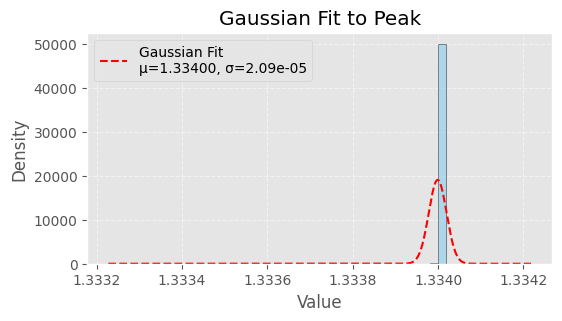

save_dir for kde_fit: c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\results\BinWidthExplorer\kde_fit\AML2_cell11
save_dir: c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\results\BinWidthExplorer\kde_fit\AML2_cell11


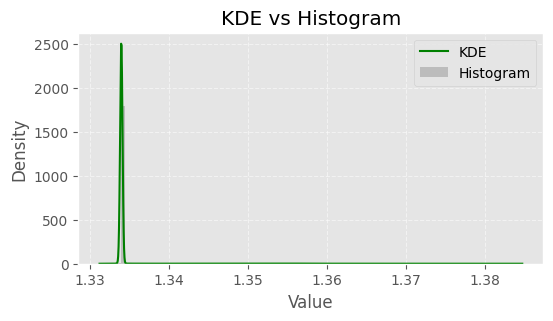

save_dir for gmm_fit: c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\results\BinWidthExplorer\gmm_fit\AML2_cell11
save_dir: c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\results\BinWidthExplorer\gmm_fit\AML2_cell11
✅ Saved .mat file for all clusters: c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\results\BinWidthExplorer\gmm_fit\AML2_cell11\cluster_coords_labels.mat
GMM plot saved to: c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\results\BinWidthExplorer\gmm_fit\AML2_cell11\gmm_fit_plot.png
GMM clusters saved in: c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\results\BinWidthExplorer\gmm_fit\AML2_cell11
 Filename     :AML3_cell16.npy
 Fullfilepath  :C:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\data\raw_npyData\AML3_cell16.npy
 k

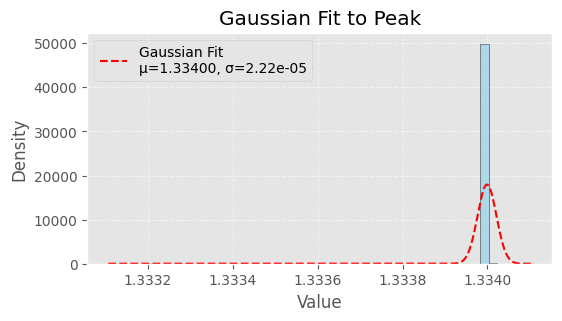

save_dir for kde_fit: c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\results\BinWidthExplorer\kde_fit\AML3_cell16
save_dir: c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\results\BinWidthExplorer\kde_fit\AML3_cell16


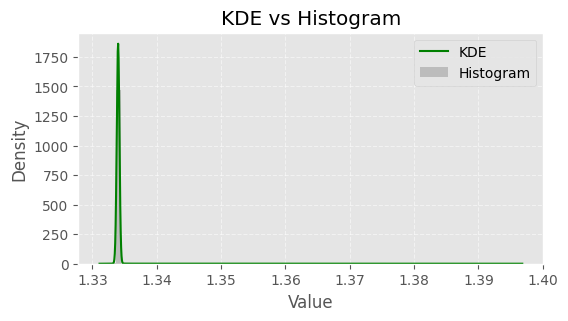

save_dir for gmm_fit: c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\results\BinWidthExplorer\gmm_fit\AML3_cell16
save_dir: c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\results\BinWidthExplorer\gmm_fit\AML3_cell16
✅ Saved .mat file for all clusters: c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\results\BinWidthExplorer\gmm_fit\AML3_cell16\cluster_coords_labels.mat
GMM plot saved to: c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\results\BinWidthExplorer\gmm_fit\AML3_cell16\gmm_fit_plot.png
GMM clusters saved in: c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\results\BinWidthExplorer\gmm_fit\AML3_cell16
 Filename     :Tomogramma_BuddingYeastCell.npy
 Fullfilepath  :C:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\data\raw_npyData\To

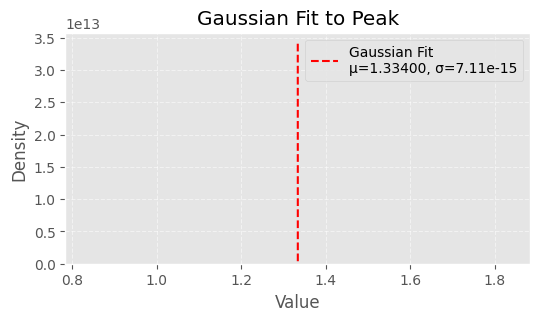

save_dir for kde_fit: c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\results\BinWidthExplorer\kde_fit\Tomogramma_BuddingYeastCell
save_dir: c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\results\BinWidthExplorer\kde_fit\Tomogramma_BuddingYeastCell


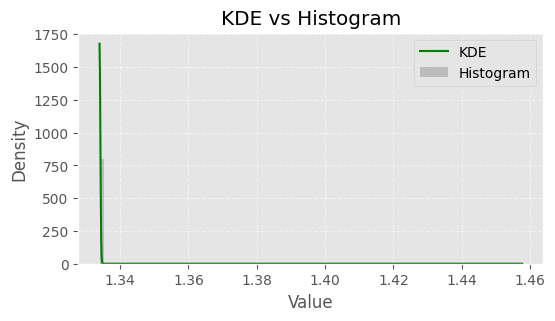

save_dir for gmm_fit: c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\results\BinWidthExplorer\gmm_fit\Tomogramma_BuddingYeastCell
save_dir: c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\results\BinWidthExplorer\gmm_fit\Tomogramma_BuddingYeastCell
✅ Saved .mat file for all clusters: c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\results\BinWidthExplorer\gmm_fit\Tomogramma_BuddingYeastCell\cluster_coords_labels.mat
GMM plot saved to: c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\results\BinWidthExplorer\gmm_fit\Tomogramma_BuddingYeastCell\gmm_fit_plot.png
GMM clusters saved in: c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\results\BinWidthExplorer\gmm_fit\Tomogramma_BuddingYeastCell
 Filename     :Tomogramma_Cell1.npy
 Fullfilepath  :C:\Users\Gaetano\Desktop\create_with_cod

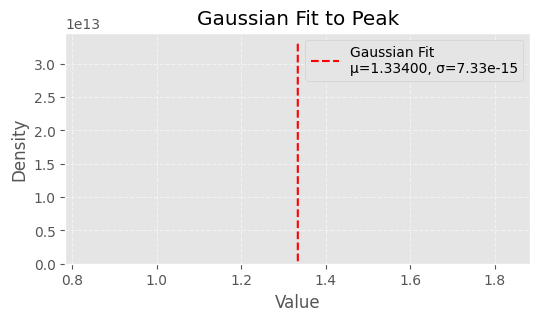

save_dir for kde_fit: c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\results\BinWidthExplorer\kde_fit\Tomogramma_Cell1
save_dir: c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\results\BinWidthExplorer\kde_fit\Tomogramma_Cell1


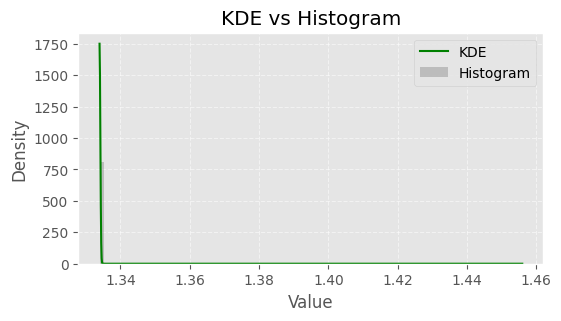

save_dir for gmm_fit: c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\results\BinWidthExplorer\gmm_fit\Tomogramma_Cell1
save_dir: c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\results\BinWidthExplorer\gmm_fit\Tomogramma_Cell1
✅ Saved .mat file for all clusters: c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\results\BinWidthExplorer\gmm_fit\Tomogramma_Cell1\cluster_coords_labels.mat
GMM plot saved to: c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\results\BinWidthExplorer\gmm_fit\Tomogramma_Cell1\gmm_fit_plot.png
GMM clusters saved in: c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\results\BinWidthExplorer\gmm_fit\Tomogramma_Cell1
 Filename     :Tomogramma_Cell2.npy
 Fullfilepath  :C:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\data\

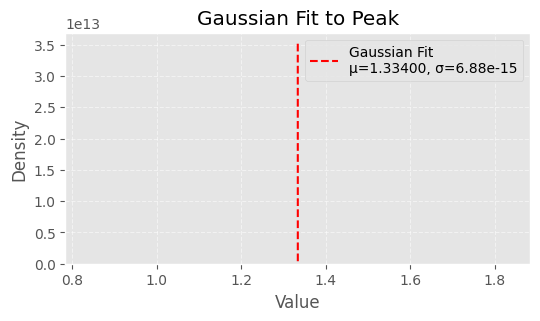

save_dir for kde_fit: c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\results\BinWidthExplorer\kde_fit\Tomogramma_Cell2
save_dir: c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\results\BinWidthExplorer\kde_fit\Tomogramma_Cell2


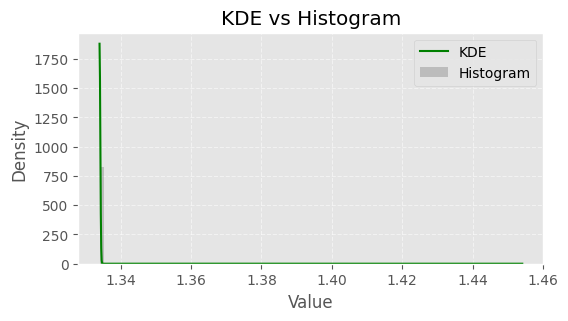

save_dir for gmm_fit: c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\results\BinWidthExplorer\gmm_fit\Tomogramma_Cell2
save_dir: c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\results\BinWidthExplorer\gmm_fit\Tomogramma_Cell2
✅ Saved .mat file for all clusters: c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\results\BinWidthExplorer\gmm_fit\Tomogramma_Cell2\cluster_coords_labels.mat
GMM plot saved to: c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\results\BinWidthExplorer\gmm_fit\Tomogramma_Cell2\gmm_fit_plot.png
GMM clusters saved in: c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\results\BinWidthExplorer\gmm_fit\Tomogramma_Cell2
 Filename     :Tomogramma_Cell3.npy
 Fullfilepath  :C:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\data\

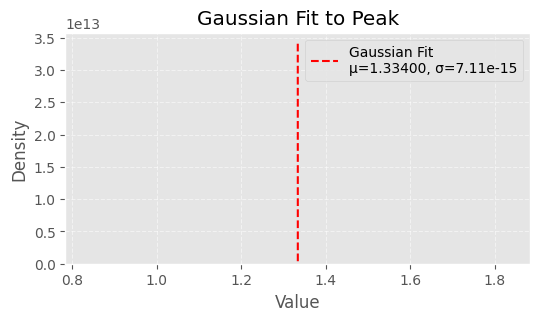

save_dir for kde_fit: c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\results\BinWidthExplorer\kde_fit\Tomogramma_Cell3
save_dir: c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\results\BinWidthExplorer\kde_fit\Tomogramma_Cell3


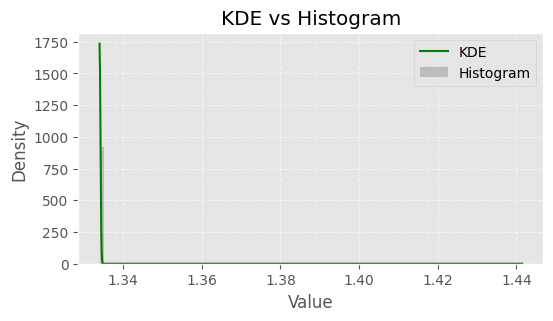

save_dir for gmm_fit: c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\results\BinWidthExplorer\gmm_fit\Tomogramma_Cell3
save_dir: c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\results\BinWidthExplorer\gmm_fit\Tomogramma_Cell3
✅ Saved .mat file for all clusters: c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\results\BinWidthExplorer\gmm_fit\Tomogramma_Cell3\cluster_coords_labels.mat
GMM plot saved to: c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\results\BinWidthExplorer\gmm_fit\Tomogramma_Cell3\gmm_fit_plot.png
GMM clusters saved in: c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\results\BinWidthExplorer\gmm_fit\Tomogramma_Cell3
 Filename     :tomo_Grafene_24h.npy
 Fullfilepath  :C:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\data\

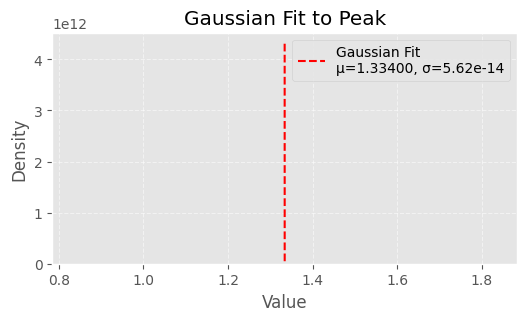

save_dir for kde_fit: c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\results\BinWidthExplorer\kde_fit\tomo_Grafene_24h
save_dir: c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\results\BinWidthExplorer\kde_fit\tomo_Grafene_24h


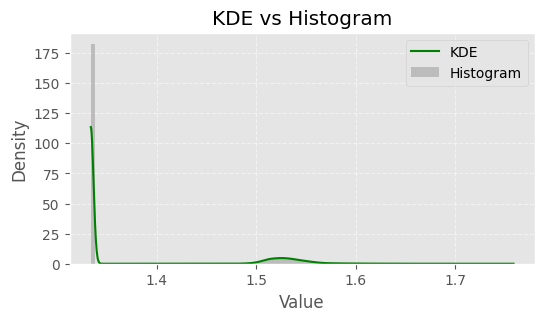

save_dir for gmm_fit: c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\results\BinWidthExplorer\gmm_fit\tomo_Grafene_24h
save_dir: c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\results\BinWidthExplorer\gmm_fit\tomo_Grafene_24h
✅ Saved .mat file for all clusters: c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\results\BinWidthExplorer\gmm_fit\tomo_Grafene_24h\cluster_coords_labels.mat
GMM plot saved to: c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\results\BinWidthExplorer\gmm_fit\tomo_Grafene_24h\gmm_fit_plot.png
GMM clusters saved in: c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\results\BinWidthExplorer\gmm_fit\tomo_Grafene_24h
 Filename     :tomo_grafene_48h.npy
 Fullfilepath  :C:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\data\

ValueError: array is too big; `arr.size * arr.dtype.itemsize` is larger than the maximum possible size.

In [3]:
import os 
from pathlib import Path
from path_manager import addpath
path = addpath()
from listspecificfiles import readlistFiles
import json
# from preprocessAll import DataPreprocessor

from preprocessAll import BinWidthExplorer
filepath1 = r"data\raw_npyData"

fpath = readlistFiles(filepath1,'.npy').file_with_Path()

filepath2Target = r"results\Data_SignificantDecimalDigits"
fpath2 = readlistFiles(filepath2Target,'.json').file_with_Path()
for file in fpath2:
    fileNameExtracted = os.path.basename(file) 
    if fileNameExtracted == "extracted_summary.json":
        print(f"fileNameExtracted: {fileNameExtracted}")
        with open(file, 'r') as f:
            summarydata = json.load(f)



base_save_dir = RES_DIR / "BinWidthExplorer"
os.makedirs(base_save_dir, exist_ok=True)  # Create if missing      

        

countf = 0
for file in fpath:
    countf += 1
    fileName = os.path.basename(file)  # these are the original data files.
    key = fileName[:-4] 
    print(f" Filename     :{fileName}\n Fullfilepath  :{file}\n key:     {key} and type of key: {type(key)}")
    data = np.load(file)
    explorer = BinWidthExplorer(data, metadata=None)
    if key == "tomo_grafene_48h":
        target_peak = summarydata[key]['mean'] 
    else:
        # target_peak = summarydata[key]['mode'] 
        target_peak = summarydata[key]['mean'] 

    print(f"target_peak: {target_peak} for key: {key}")  

    decimal_place = summarydata[key]['max_decimal_digit'] 
    print(f"decimal_place: {decimal_place}")

    decimal_place = int(decimal_place)  # Convert to integer because it is stored as a string in the JSON file

    tolerance = 0.000001  # Adjust tolerance as needed
    save_dirpeakIteration =  base_save_dir/ "peak_fitting" / fileName[:-4]
    os.makedirs(save_dirpeakIteration, exist_ok=True)  # Create if missing
    save_dir = save_dirpeakIteration
    print(f"save_dir: {save_dir}")

    result = explorer.evaluate_binwidth_range(decimal_place=decimal_place, plot=True, save_dir=None, target_peak=target_peak, tolerance=tolerance)

           
   ## ------------ this below section for the gaussian fit ----------------
    peak_range = result['peak_bin_edges']
    print(f"peak_range: {peak_range} for file: {fileName}")
    save_guassian = base_save_dir / "gaussian_fit" / fileName[:-4]
    os.makedirs(save_guassian, exist_ok=True)  # Create if missing   
    print(f"save_dir for gaussian_fit: {save_guassian}")
    save_dir = save_guassian  # None means current directory
    print(f"save_dir: {save_dir}")
    mu, std, peak_data = explorer.fit_gaussian_to_peak(result['peak_bin_edges'], save_dir = save_dir)
   # --------------------------- END of gaussian fit  ----------------


    ##  ------------ this below section for the kde fit  ------------
    save_kde = base_save_dir / "kde_fit" / fileName[:-4]    
    os.makedirs(save_kde, exist_ok=True)  # Create if missing
    print(f"save_dir for kde_fit: {save_kde}")
    save_dir = save_kde  # None means current directory
    print(f"save_dir: {save_dir}")
    explorer.plot_kde_comparison(save_dir=save_dir)
    # print(f"kde_vals: {kde_vals} and kde_x: {kde_x} for file: {fileName}")
   # --------------------------- END of kde fit ----------------

    #  ------------ this  below section for the GMM fit  ------------
    save_gmm = base_save_dir / "gmm_fit" / fileName[:-4]
    os.makedirs(save_gmm, exist_ok=True)  # Create if missing
    print(f"save_dir for gmm_fit: {save_gmm}")
    save_dir = save_gmm  # None means current directory
    print(f"save_dir: {save_dir}")
    explorer.fit_gmm_and_save(n_components=2, save_dir=save_dir,save_mat=True, plot=True)
   # --------------------------- END of gmm fit ----------------
    
 
    if countf == 8:
        break


This below code is for the utilizing the DatPreprocessor class for qunatile based thresholding and plotting the all in one and showing the qunatile threshold vertical lines. 

In [ ]:
# import os 
# from path_manager import addpath
# path = addpath()

# from preprocessAll import DataPreprocessor
# from preprocessAll import BinWidthExplorer

# from listspecificfiles import readlistFiles
# filepath1 = r"data\raw_npyData"

# fpath = readlistFiles(filepath1,'.npy').file_with_Path()

# countf = 0
# d_test = np.random.normal(0, 1, 100)

# for file in fpath:
#     countf += 1
#     print(f"{file} and filepath : ")
#     # data = np.load(file).flatten()
#     # data = data[data>1.336]
#     data = d_test  # arbitary data 
#     DataPreprocessor.quantile_based_auto_threshold_plot(data, n_peaks=6, colors=None, show_subplots=False, save_dir=None)
#     if countf == 1:
#         break


In [ ]:
""" Testing the certain things and doubts ------------------------------------ """

# data = np.array([1.0, 1.1, 1.1, 1.2, 1.3, 1.3, 1.3, 1.35, 1.4, 1.5, 1.5, 1.6])
# counts, edges = np.histogram(data, bins=5)
# print(f"counts:{counts}\n edges:{edges}\n peak:{max(counts)} ")
# print(f"ed : {edges[:-1]} \n ed_all:{edges[1:]}")
# fig, ax = plt.subplots(figsize=(4,4))
# x = np.linspace(0,6,20)
# y1 = np.sin(x)
# ax.plot(x,y1)
# ax.plot(x,np.cos(x))
# # plt.show()
# x = np.random.randint(0,5,(2,3))
# print(x)
# # x1= np.ones([2,3])
# x1= np.ones_like(x)
# x1

########## --------------- test 2 -----------------------
# import numpy as np
# data = np.random.normal(loc=5, scale=1.5, size=1000)
# counts, bin_edges = np.histogram(data, bins='auto')
# plt.hist(data,bins='auto')
# plt.show()
# peak_index = np.argmax(counts)
# peak_range = (bin_edges[peak_index], bin_edges[peak_index + 1])
# peak_center = np.mean(peak_range)

# print("Peak bin range:", peak_range)
# print("Peak bin center (most common value approx.):", peak_center)


' Testing the certain things and doubts ------------------------------------ '

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
# cov = [[0,0,0],[0,1,0],[0,0,1]]
# mean = [0,2,4]
# # d_test = np.random.multinomial(100, [1.0 / 3, 2.0 / 3])
# d_test = np.random.rand(10000)
d_test = np.random.normal(0, 1, 100)

plt.hist(d_test)
# plt.hist(d_test)
plt.show()
d1_test = np.copy(d_test)

Qvalue = []
for i in range(1, 5):
    Qi = 1/i
    qunatileVal = np.quantile(d_test, Qi)
    # Qdata = {f"Q_{Qi}": qunatileVal}
    print(f" qi percentile: {Qi*100:.2f} and n\ Threshold Value for {Qi*100:.2f} percentile: {qunatileVal} \n --> ") # {d_test[d_test>qunatileVal]}"
    dataP = d_test[d_test>qunatileVal] # data after removing the background.
    Qdata = {f"Q_thres": qunatileVal, f"fg_data":dataP}

    Qvalue.append(Qdata)

def plot_combined(Qval, fgdata):
    # Qy = Qval*np.ones_like(d_test)
    x_axis = np.linspace(min(d_test),max(d_test),len(d_test))
    
    x = Qval*(np.ones_like(x_axis))
    Qy = np.linspace(0,20,len(x_axis))
    # x = np.ones_like()
    
    # ax = plt.figure(figsize=(4,4))
    ax.hist(d1_test)
    ax.hist(fg_data)
    ax.plot(x,Qy)
    # ax.hist(fg_data,bins='fd')
    # plt.show()

fig,ax= plt.subplots()

for iteration in Qvalue:
    QThresValue = iteration["Q_thres"]
    fg_data = iteration["fg_data"]

    plot_combined(QThresValue,fg_data)

plt.show()

In [ ]:
# x = np.linspace(0, 10, 10)
# y1 = np.sin(x)
# y2 =  y1 + 2
# plt.plot(x, y1, label='sin(x)')
# plt.plot(x, y2, label='sin(x) + 2')
# plt.show()
# file[-5:-4]
filepath = r"C:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\data\raw_npyData\Tomogramma_Cell.npy"
import numpy as np
import os
filename = os.path.basename(filepath)
print(f"Extracted name is Tomogramam : {filename[0:10]} and length : {len(filename[0:10])}")

# filename = os.path.basename(filepath)

In [ ]:
# finding resolution of data, so not to skip small varaition,
# First just plot Raw Data after making flat, if it is equal and more than 2 dimensions -> data = data.flatten()
# x_data = np.linspace(min(data),max(data),len(data)), data = data.flatten() ---> y_data  =  sorted_data = np.sort(data)

# binsize = diff(choosen smallest values after sorting the data) : data = data.flatten().reshape(-1,1)
# 201*201*201 = 8120601; 200*200*200 = 8000000;
# :.2e	1.23e-05	2 decimal places
# :.8e	1.23456000e-11	8 decimal places
# # Print with scientific notation and 8 decimal places
# print(f"{value:.8e}

from pathlib import Path
from listspecificfiles import readlistFiles
import numpy as np
import matplotlib.pyplot as plt
import os

from path_manager import addpath
paths = addpath()
data_path = r"data\raw_npyData"  # relative path with r""relativepath"
files = readlistFiles(data_path, '.npy')
fpath = files.file_with_Path()  # file with path name.
BASE_DIR = Path.cwd().parent
print(f"BASE_DIR:--------> {BASE_DIR}")
save_pathtTEXT = BASE_DIR/"results"

################################ for simple plot of data ##############################################

def simple_plot(data, file, savepathplot):
    x_data = np.linspace(min(data), max(data), len(data))
    # fig = plt.figure(figsize=(10,6))
    plt.figure(figsize=(10, 6))
    plt.scatter(x_data, data, s=0.1)
    plt.title(f"{os.path.basename(file)[:-4]} sortred Data ")
    plt.xlabel('Data: linearly spaced data itself')
    plt.ylabel('Data:RI_value')
    plt.grid(True)
    save_dir = BASE_DIR/"results"/"rawData_XYPlot"/"plotSortedData"
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, f"{os.path.basename(file)[:-4]}")
    plt.savefig(save_path, dpi=300)
#####################################################################################################

textFilesSave = os.path.join(save_pathtTEXT, 'details_Datafile.txt')
with open(textFilesSave, 'w') as f:
    f.close()
# count = 0
for file in fpath:
    # count +=1
    fileName = os.path.basename(file)
    # print(f"FullfilePath:{file} \n fileName:{fileName}")

    data = np.load(file)
    Data_shape = data.shape
    data = data.flatten()
    sorted_data = np.sort(data)
    # simple_plot(sorted_data,file,BASE_DIR)

    diff_1data = np.diff(sorted_data)
    # diff_2data = np.diff(sorted_data)

# ------------------------  found zeros in the diff1, Now filter zeros then go for first and second nonzero values --------------
    # Filter out exact or near-zero differences to avoid duplicates
    prcsn = 1e-9  # set precison
    nonzero_diffs = diff_1data[np.abs(diff_1data) > prcsn]

    # Use np.unique to get distinct difference values
    unique_diffs = np.unique(nonzero_diffs)

    # Extract min and second min, keeping 9 decimal precision
    # for unique_val in range(unique_diffs):
    min_val = unique_diffs[0]
    second_min_val = unique_diffs[1] if len(unique_diffs) > 1 else None

    # Print values with high precision
    print(
        f"Minimum difference {fileName}  : {min_val:.12f} i.e. {min_val:.12e}")
    if second_min_val is not None:
        print(
            f"Second minimum difference {fileName}: {second_min_val:.12f} i.e. {second_min_val:.12e}")
    else:
        print("No second unique non-zero difference found.")

    # print(f"RESOLUTION_DATA: {min(diff_1data):.8f} DATA SIZE: {sorted_data.shape} \n lower value:{sorted_data[0:3]} and upper value:{sorted_data[-4:]}")
    # text_data = f"{fileName}: Data_shape:{Data_shape}, DATA SIZE: {sorted_data.shape}, RESOLUTION_DATA: {min(diff_1data)},lower value:{sorted_data[0:3]}, upper value:{sorted_data[-3:]}\n"
    # with open(textFilesSave,'a') as f:
    #     f.write(text_data)

In [ ]:
# import numpy as np
# # np.unique_counts(nonzero_diffs)
# a = np.array([1, 2, 4, 3, 2])
# # values,count = np.unique(a, return_counts=True) # return_counts -returns the unique value counts.
# # print(f"a:{a.shape} \n values:{values} \n count:{count} \n")
# print(f"a:{a.shape} \n")
# # a = np.array([1.3312498765,1.3312498761,1.3312498712,1.3312498763,1.3312498768,1.3312498765])
# # a  = np.sort(a)
# # a = list(a)
# f,count,inv,count1 = np.unique(np.round(a,decimals= 11), return_counts=True,return_inverse=True,return_index = True)
# # print(f"a : {float(a)} and its size: {len(a)}")
# print(f"a : {a} and its size: {len(a)}")

# # f,idx1,count = np.unique(a,return_index = True, return_counts=True)
# f,count1,count,inv

In [ ]:
# x = 1.01e-9
# print(f"val:{x:.11f}")

In [ ]:
# str1 = '1.000010200000'
# tt1 = str1.rstrip('0')   # eliminate the trailing zeros.
# tt1
# # 'Hello world'.title()  # 'Hello World'
# # "they're bill's friends from the UK".title() #"They'Re Bill'S Friends From The Uk"
# # "42".zfill(5)  # padding of total 5 including the "42", so three zeros (000) will be added at starting. 
# str2 = 'janakak'
# str2.replace('k','R')


## - below code find the significant digits in my data and plot the histogram: 
##💡  it tells you how many digits are non-zero or meaningful in the float’s scientific representation.

##💡 It’s a heuristic method — useful for checking how many digits "matter" in terms of numerical precision.

##💡 np.unique(data): --> it always return the results in the order uniqValues(sorted array of unique values in increasing Order).

##💡idx: (first index of each unique values in the original data).

##💡inverse_idx:  

##💡counts : returns counts of each values in unique array.

<!-- Total_res = np.unique(significant_digit_data,return_counts=True,return_index=True,return_inverse=True)
    uniqValues,idx,inverse_idx,counts = Total_res  #  -->

In [ ]:
import numpy as np
def UniqueValueCount(data):
    """
    give your data in numpy array format 1d: 
    uniqValues,idx,inverse_idx,counts reurn values in this order
    get your results:, it will return Total_res then extract these: uniqValues,idx,inverse_idx,counts
    extract like this : uniqValues,idx,inverse_idx,counts = Total_res
    """
    significant_digit_data = data
    # uniqValues,idx,inverse_idx,counts = np.unique(significant_digit_data,return_counts=True,return_index=True,return_inverse=True)
    Total_res = np.unique(significant_digit_data,return_counts=True,return_index=True,return_inverse=True)
    uniqValues,idx,inverse_idx,counts = Total_res
    print(f"\n unique values:{uniqValues},\n  Unique counts: {counts} and \n indexes:{idx}, \n reverse_idx : {inverse_idx} and \n orginal Array :{uniqValues[inverse_idx]}")
    return Total_res

data = np.array([1,2,4,3,2])
UniqueValueCount(data)

In [ ]:
############################# DOES NOT WORKED ALWAYS GAVE 18/19 DECIMAL DIGITS PRECISION FOR ALL DATA --> becasue of formatting f"{val:.18f}" 

# def significant_digits(val):
#     """Extract first significant digit (ignores sign and zeros)."""
#     val = float(val)
#     if val == 0:
#         return 0
#     my_strVal = str(val)  
#     return int(my_strVal.lstrip('-0.')[0])

# def decimal_places(val):
#         s = f"{val:.18f}".rstrip('0')
#         if '.' in s:
#             return len(s.split('.')[1])
#         return 0 


In [6]:

# useful for checking how many digits "matter" in terms of numerical precision.

from  pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from collections import defaultdict
import json
from scipy import stats

from path_manager import addpath
paths = addpath()

import csv
from listspecificfiles import readlistFiles

from plot_dataModule import DataPlotter  # import DataPlotter from plot_dataModule.py file, all the functions are defined realted to plot the histogram and save it in the directory and simple raw data plot.

from data_saver_module import DataSaver # import DataSaver from data_saver_module.py file, all the functions are defined related to save the data in the directory.

data_path = r"data\raw_npyData"  # relative path with r""relativepath"
files = readlistFiles(data_path,'.npy')
fpath = files.file_with_Path()  # file with path name.

# Directory to save histograms
BASE_DIR = Path.cwd().parent
save_dir = BASE_DIR/"results"/"histogram_significantDigits"
os.makedirs(save_dir,exist_ok=True)


############################# this is the function to find number of decimal points values after decimal in right side of decimal (show precision) #####################
import math
from decimal import Decimal
def actual_significant_digits_after_decimal(val):
    """Returns number of digits after the decimal in original float (ignoring trailing zeros).
        handle the inf and NaN values also in the data. return zeros in this case.
    """

    if math.isinf(val) or math.isnan(val):
        return 0  # Or return None to indicate 'not countable'
    
    if val == 0:
        return 0
    d = Decimal(str(val)).normalize()
    if '.' not in str(d):
        return 0
    return len(str(d).split('.')[1].rstrip('0'))

##################################################################################################

####################################### This is for the Find the Unique values and used to find Maximum precision value in data. ###########################################################
import numpy as np
def UniqueValueCount(data):
    """
    give your data in numpy array format 1d: 
    uniqValues,idx,inverse_idx,counts reurn values in this order
    get your results:, it will return Total_res then extract these: uniqValues,idx,inverse_idx,counts
    extract like this : uniqValues,idx,inverse_idx,counts = Total_res
    """
    significant_digit_data = data
    # uniqValues,idx,inverse_idx,counts = np.unique(significant_digit_data,return_counts=True,return_index=True,return_inverse=True)
    Total_res = np.unique(significant_digit_data,return_counts=True,return_index=True,return_inverse=True)
    uniqValues,idx,inverse_idx,counts = Total_res
    return Total_res
    print(f"\n unique values:{uniqValues},\n  Unique counts: {counts} and \n indexes:{idx}, \n reverse_idx : {inverse_idx} and \n orginal Array :{uniqValues[inverse_idx]}")

# data = np.array([1,2,4,3,2])
# UniqueValueCount(data)


##################################################################################################

# proceess all files in the directory and generate histogram for each file and save it in the directory. all the auxiliary functions are defined in the same Cell, are used in this code.
save_dir1 = BASE_DIR/"results"/"histogram_3splitSgnfctDigits"

import pandas as pd

countfile = 0
for FileWithPath in fpath:
    countfile +=1
    print(f"FileWithPath: {FileWithPath} and countfile: {countfile}")

    # this was just to test the code, so not to process all files in the directory.
    # if countfile <=4 or countfile >=6 :
    #     print(f"Ignored file .: {countfile}")
    #     # break
    #     continue
    
    print(f"Processed file .: {countfile}")

    filename = os.path.basename(FileWithPath)
    print(f"Processing filename: {filename}")
    
    # Load and flatten data
    data = np.load(FileWithPath)
    data = data.flatten()
    print(f"Shape of data: {data.shape[0]}")
    
    # Extract first significant digit
    # significant_digit_data = [significant_digits(val) for val in data if val != 0]
    # significant_digit_data = [actual_significant_digits_after_decimal(val) for val in data if val != 0]

    # Step 2: Build significant_digit_data + track actual values using defaultdict
    decimal_digit_groups = defaultdict(list)
    significant_digit_data = []
    csv_rows = []

    for val in data:
        if val != 0:
            d = actual_significant_digits_after_decimal(val)
            decimal_digit_groups[d].append(val)
            significant_digit_data.append(d)

    # Plot histogram
    UniqueValues = UniqueValueCount(significant_digit_data)[0]
    Counts_OFUniqueValues = UniqueValueCount(significant_digit_data)[3]
    x_axis_maxValueHist =  max(UniqueValues)

    ##############  for finding the corresponding statistics of each decimal digits precision and saving in json #############################

    # BASE_DIR = Path(".")  # replace with actual base dir if needed
    Data_sgnDecimalDgts_save_dir = BASE_DIR / "results" / "Data_SignificantDecimalDigits"
    os.makedirs(Data_sgnDecimalDgts_save_dir, exist_ok=True)

    # Final dictionary to store stat_summary + values
    decimal_digit_group_stats = {}   # dictionary with stats and values list 
    decimal_digit_group_stats_OnlySummary = {} # dictionary of stat summary only

    for d, values in decimal_digit_groups.items():
        values_arr = np.array(values, dtype=np.float64)

        mode_result = stats.mode(values_arr,keepdims=True)
        
        stat_summary = {
            "count": int(len(values_arr)),
            "min": float(np.min(values_arr)),
            "max": float(np.max(values_arr)),
            "mean": float(np.mean(values_arr)),
            "median": float(np.median(values_arr)),
            "mode": float(mode_result.mode[0]),  
            "modeCounts": int(mode_result.count[0]),
            "std": float(np.std(values_arr)),
            "values": [float(f"{v:.17g}") for v in values_arr]
        }

        decimal_digit_group_stats[str(d)] = stat_summary

        print(f"Decimal Digit: {d}")
        print(f"  Count         : {stat_summary['count']}")
        print(f"  Min           : {stat_summary['min']}")
        print(f"  Max           : {stat_summary['max']}")
        print(f"  Mean          : {stat_summary['mean']}")
        print(f"  Median        : {stat_summary['median']}")
        print(f"  Mode          : {stat_summary['mode']}")
        print(f"  ModeCounts    : {stat_summary['modeCounts']}")
        print(f"  Std Dev       : {stat_summary['std']}")
        print("-" * 40)

    #-------------------  This below section is for saving the summary ONLY  in csv and json file. Each available significant digits details summary only is saved in a corresponding file. 
          
        stats_summary_Without_ValueList = {
            "decimal_digit": d,
            "count": int(len(values_arr)),
            "min": float(np.min(values_arr)),
            "max": float(np.max(values_arr)),
            "mean": float(np.mean(values_arr)),
            "median": float(np.median(values_arr)),
            "mode": float(mode_result.mode[0]),
            "modeCounts": int(mode_result.count[0]),
            "std": float(np.std(values_arr))
        }
        # Save summary stats for JSON (without raw values)
        decimal_digit_group_stats_OnlySummary[str(d)] = stats_summary_Without_ValueList

        # Save summary stats for CSV
        csv_rows.append(stats_summary_Without_ValueList)

        # --------------- Save to JSON and csv for SUMMARY ONLY  -------------------------------------
    json_path = Data_sgnDecimalDgts_save_dir / f"summaryStats_ONLY{filename[:-4]}.json"
    with open(json_path, "w") as jf:
        json.dump(decimal_digit_group_stats_OnlySummary, jf, indent=4)

    # Save CSV
    csv_path = Data_sgnDecimalDgts_save_dir / f"summaryStats_ONLY{filename[:-4]}.csv"
    with open(csv_path, "w", newline="") as cf:
        writer = csv.DictWriter(cf, fieldnames=csv_rows[0].keys())
        writer.writeheader()
        writer.writerows(csv_rows)

    json_path, csv_path

    # --------------- Save to JSON  for all summary and stats -------------------------------------
    save_path = Data_sgnDecimalDgts_save_dir / f"significantDec{filename[:-4]}.json"

    with open(save_path, "w") as f:
        json.dump(decimal_digit_group_stats, f, indent=4)

    print(f"Stats and values saved to: {save_path}")   

# ---------- !!!!!!!!!!!!!!!!!!!! from here I use continue to avoid further processing ................................ !!!!!!!!!!!!!!!!!
    if countfile >= 1:   # For ignoring the saving the histogram and its plotting.
        print(f"will not continue forward from here .....  metdata list")
        continue
        
    metadata_list = [
        {
            "filename": f"{filename[:-4]}",

            
            "unique_values": UniqueValues.tolist(),  # Convert numpy array to list
            "counts": Counts_OFUniqueValues.tolist(),  # Convert numpy array to list
            "significant_DecimalDigits": int(x_axis_maxValueHist),  # Convert numpy.int64 to int
            "significant_digit_data": significant_digit_data  # significant decimal digits for each data value in the data array (which are converted from 3d numpy to 1d array).
        }
    ]
    
################################### this is to save the metadata in the json file. #######################################################################################

    from data_saver_module import DataSaver
    Data_sgnDecimalDgts_save_dir = BASE_DIR/"results"/"Data_SignificantDecimalDigits"
    os.makedirs(Data_sgnDecimalDgts_save_dir, exist_ok=True)  # Create if missing
    saver = DataSaver(save_dir=Data_sgnDecimalDgts_save_dir, include_fields=[], filename=f"{filename[:-4]}.json")
    saver.save(metadata_list)

    print(F"HERE precision  digits in the data values: {x_axis_maxValueHist}")

    # <----------------  JUST CHOOSE ONE OF THE FOLLOWING HISTOGRAMS TO PLOT AND SAVE IT. JUST UNCOMMENT ANY ONE ----------- >

 ############### 1ST --  invoke the function to plot histogram with color coding and annotation

    # if countfile >=1:   # for ignoring the saving the histogram and its plotting.
    #     continue

    DataPlotter.plot_histogram_with_annotate_counts(
        Counts_OFUniqueValues,
        UniqueValues,
        title=f"{filename[:-4]}: Annotated Histogram",
        xlabel=f"Significant Digit (1–{max(UniqueValues)})",
        ylabel="Normalized Frequency (Fixed Height)",
        saveplot=False,
        filename=filename[:-4],
        save_dir=save_dir,
        dpi=600  # Publication-ready resolution
    )

# 2ND -- invoke the function to plot histogram Here HORIZONTAL SPLIT HISTOGRAM : with color coding and annotation
    DataPlotter.plot_horizontal_split_histogram(
        significant_digit_data=significant_digit_data,
        title=f"{filename[:-4]}: Annotated Histogram",
        xlabel="Frequency of Occurrence",
        ylabel=f"Significant Digit (1–{max(UniqueValues)})",
        saveplot=False,
        filename=filename[:-4],
        save_dir=save_dir1
    )
    
print(f"Total number of files processed: {countfile} and plot generated for each file if saveplot is True.")

################################ older version of histogram plot with color coding and annotation ###############
    # plt.figure(figsize=(8, 5))
    # plt.hist(significant_digit_data,bins='auto')
    # plt.title(f"Significant Digit Histogram: {filename}")
    # plt.xlabel(f"Significant Digit (1-{max(UniqueValues)})")
    # plt.ylabel("Frequency")
    # plt.xticks(range(1, max(UniqueValues)+1))
    # plt.grid(True)
    # plt.show()
    # Save the figure
    # hist_path = os.path.join(save_dir, f"{filename[:-4]}_histogram.png")
    # plt.savefig(hist_path)
    # plt.close()
    # Optional: Print most common digit
    # most_common_digit = np.argmax(counts) + 1  # bins are 1-indexed
    # print(f"Most frequent significant digit: {most_common_digit}")


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
FileWithPath: C:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\data\raw_npyData\AML2_cell11.npy and countfile: 1
Processed file .: 1
Processing filename: AML2_cell11.npy
Shape of data: 8000000
Decimal Digit: 3
  Count         : 7604888
  Min           : 1.334
  Max           : 1.334
  Mean          : 1.3339999999999894
  Median        : 1.334
  Mode          : 1.334
  ModeCounts    : 7604888
  Std Dev       : 1.0658141036401503e-14
----------------------------------------
Decimal Digit: 16
  Count         : 307530
  Min           : 1.3312461759020122
  Max           : 1.3847334887289884
  Mean          : 1.3472142328933567
  Median        : 1.3490491243512532
  Mode          : 1.3339985923526747
  ModeCounts    : 6
  Std Dev       : 0.010078631184466499
--------------------------

In [59]:
# import json
# from pathlib import Path
# from listspecificfiles import readlistFiles

# datapath = r"results\Data_SignificantDecimalDigits"
# files = readlistFiles(datapath, '.json')
# # files = [filename for filename in files if filename[:]]
# fpath = files.file_with_Path()  # fileName with path name.
# actualfilename  = []
# for file in fpath:
#     fileName = os.path.basename(file)
#     # print(f"Processing fileName: {fileName}")
#     if fileName.startswith('summaryStats_ONLY'):

#         actualfilename.append(fileName[len('summaryStats_ONLY'):])
#         print(f"Processing fileName: {fileName} and actual filename: {actualfilename[-1]}")
#         with open(file, 'r') as f:
#             data = json.load(f)
#             if fileName == 'summaryStats_ONLYtomo_grafene_48h.json':
#                 print(f"\n📂 Processing file: {fileName}")
#                 with open(file, 'r') as f:
#                     data = json.load(f)

#                 max_count = -1
#                 max_key = None

#                 for key, stats in data.items():
#                     count_val = stats.get("count")
#                     if count_val is not None and count_val > max_count:
#                         max_count = count_val
#                         max_key = key

#                 if max_key:
#                     stats = data[max_key]
#                     print(f"🔍 Key with maximum count: {max_key}")
#                     print(f"📊 Mean: {stats['mean']}")
#                     print(f"📈 Std Dev: {stats['std']}")
#                     print(f"📌 Mode: {stats['mode']}")
#                 else:
#                     print("⚠️ No valid 'count' found in data.")


#             # Extract statistics for significant digit 3
#             else:  
#                 meanVal = data["3"]["mean"]
#                 mode = data["3"]["mode"]
#                 std = data["3"]["std"]
#                 print(f"Mean: {meanVal}, Mode: {mode}, Std Dev: {std}")
            

#     # print(f"Processing fileName:  and filename: {filen1}")


In [ ]:
""" this code  read all the json extrcated files with summary and stats of ecah significant decimal digits and extract the maximum count and its corresponding key, mean, std and mode values.
 and save it in a extracted_summary.json file with only maximum counts statistics values like key filename withot extension , max_decimal_digit: as you can see example :
 {
    "AML2_cell11": {
        "max_decimal_digit": "3",
        "max_count": 7604888,
        "mean": 1.3339999999999894,
        "std": 1.0658141036401503e-14,
        "mode": 1.334
    },
    .
    .
    .
    "tomo_grafene_48h": {
        "max_decimal_digit": "18",
        "max_count": 5670279,
        "mean": 0.00858388297105225,
        "std": 0.016879311489506044,
        "mode": -0.062485889286222465
    }
}
this  is the content of the extracted_summary.json file.
"""
import json
from pathlib import Path
from listspecificfiles import readlistFiles
import os
datapath = r"results\Data_SignificantDecimalDigits"
files = readlistFiles(datapath, '.json')
# files = [filename for filename in files if filename[:]]
fpath = files.file_with_Path()  # fileName with path name.
actualfilename  = []
extracted_data = {}  # Dictionary to store extracted data
for file in fpath:
    fileName = os.path.basename(file)
    # print(f"Processing fileName: {fileName}")
    if fileName.startswith('summaryStats_ONLY'):

        actualfilename.append(fileName[len('summaryStats_ONLY'):])
        print(f"Processing fileName: {fileName} and actual filename: {actualfilename[-1]}")
        with open(file, 'r') as f:
            data = json.load(f)

            max_count = -1
            max_key = None

            for key, stats in data.items():
                count_val = stats.get("count")
                if count_val is not None and count_val > max_count:
                    max_count = count_val
                    max_key = key

            if max_key:
                stats = data[max_key] # here [:-5] because i will just take name without .json extension
                extracted_data[actualfilename[-1][:-5]] = {
                    "max_decimal_digit": max_key,
                    "max_count": max_count,
                    "mean": stats['mean'],
                    "std": stats['std'],
                    "mode": stats['mode']
                }

        # Save to a new JSON file
# Define the save directory path as a plain string
BASE_DIR = os.path.dirname(os.getcwd())  # Parent of current working directory
savepath = os.path.join(BASE_DIR, "results", "Data_SignificantDecimalDigits")

# Create the directory if it doesn't exist
os.makedirs(savepath, exist_ok=True)

# Define the full path for the JSON file to be saved
jsonFilename = 'extracted_summary.json'
jsonfilesave = os.path.join(savepath, jsonFilename)

# Save the data
with open(jsonfilesave, 'w') as out_file:
    json.dump(extracted_data, out_file, indent=4)



Processing fileName: summaryStats_ONLYAML2_cell11.json and actual filename: AML2_cell11.json
Processing fileName: summaryStats_ONLYAML3_cell16.json and actual filename: AML3_cell16.json
Processing fileName: summaryStats_ONLYTomogramma_BuddingYeastCell.json and actual filename: Tomogramma_BuddingYeastCell.json
Processing fileName: summaryStats_ONLYTomogramma_Cell1.json and actual filename: Tomogramma_Cell1.json
Processing fileName: summaryStats_ONLYTomogramma_Cell2.json and actual filename: Tomogramma_Cell2.json
Processing fileName: summaryStats_ONLYTomogramma_Cell3.json and actual filename: Tomogramma_Cell3.json
Processing fileName: summaryStats_ONLYtomo_Grafene_24h.json and actual filename: tomo_Grafene_24h.json
Processing fileName: summaryStats_ONLYtomo_grafene_48h.json and actual filename: tomo_grafene_48h.json


In [ ]:
# from scipy import stats
# x = [1,1,1,1,2,5,6,7,8,9]
# # mode_result = stats.mode(x,keepdims=True)
# # print(mode_result)
# # mode_result = stats.mode(values_arr, keepdims=True)
# # print("Mode:", mode_result.mode[0])
# # print("Count:", mode_result.count[0])
# print(f"Mode:", {float(stats.mode(x,keepdims=True).mode[0])})
# # print(f"Count:", int({stats.mode(x,keepdims=True).count[0]}))
# print(40*"-")
# import pandas as pd
# import os

# # Folder containing your CSV files
# folder_path = r"E:\Projects\substructure_3d_data\Substructure_Different_DataTypes\results\Data_SignificantDecimalDigits"

# # Set your folder path


# output_file = os.path.join(folder_path, "combined_file.csv")

# # Open the output file in write mode
# with open(output_file, 'w', encoding='utf-8', newline='') as f_out:
#     for file in os.listdir(folder_path):
#         if file.endswith(".csv") and file[:-4] != 'combined_file':
#             file_path = os.path.join(folder_path, file)
            
#             # Write file name as a row
#             f_out.write(f"{file[17:-4]}\n")
            
#             # Read data and write to file
#             df = pd.read_csv(file_path)
#             df.to_csv(f_out, index=False)
            
#             # Write an empty line as separator
#             f_out.write("\n")

# print(f"file is cretaed with combined data: \n ------")

In [ ]:
# ff = "summaryStats_ONLY"
# count = 0 
# for i in ff:
#     count +=1
#     print(i,count,end=' ')

# print(f" \n {count}, {len(ff)}")

In [ ]:
# Re-import necessary libraries after reset
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label

def Peak_Detect_BackgroundThreshold(flat_data, save_path=None):
    """
    Analyze a flat data array, plot its histogram, and save the plot.
    
    Parameters:
        flat_data (numpy.ndarray): 1D array of data values.
        save_path (str): Path to save the histogram plot.
    """
    # Compute histogram
    # Choose binning method
    # binning_method = input("Choose binning method (sturges, doanes, freedman-diaconis, auto): ").strip().lower()
    if binning_method in ['sturges', 'doanes', 'fd']:
        counts, bin_edges = np.histogram(flat_data, bins=binning_method)
    else:
        counts, bin_edges = np.histogram(flat_data, bins=5000)  # Default to 'auto' if input is invalid

    peak_idx = np.argmax(counts)  # index of the peak

    # Thresholding and labeling
    threshold = 0.6 * counts[peak_idx]  # 60% of peak value
    mask = counts >= threshold
    labeled, num_features = label(mask)

    peak_label = labeled[peak_idx]
    range_idxs = np.where(labeled == peak_label)[0]
    range_start = bin_edges[range_idxs[0]]
    range_end = bin_edges[range_idxs[-1] + 1]

    # Plot
    plt.figure(figsize=(10, 5))
    plt.bar(bin_edges[:-1], counts, width=np.diff(bin_edges), edgecolor='black', label='Histogram', align='edge')
    plt.axhline(threshold, color='red', linestyle='--', label=f'Threshold ({threshold:.1f})')
    plt.axvspan(range_start, range_end, color='orange', alpha=0.3, label=f'Connected Region ({range_start:.2f}-{range_end:.2f})')
    plt.scatter(bin_edges[peak_idx], counts[peak_idx], color='blue', zorder=5, label='Peak')
    plt.title(f'Connected Region Around Peak{filename[:-4]}')
    plt.xlabel('RI Value')
    plt.ylabel('Count')
    plt.ylim(0, 900)  # Extend y-axis for better visibility
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()
    print(f"Histogram saved to {save_path}")
    return range_start, range_end, threshold, peak_label



# Re-import necessary packages after code execution state rese

# Simulate example data with background noise and signal
# np.random.seed(0)
# background = np.random.normal(loc=1.334, scale=1e-12, size=100000)  # very fine, dominant background
# signal = np.random.normal(loc=1.335, scale=1e-10, size=5000)        # weaker signal cluster
# data = np.concatenate([background, signal])
def peak_range(data, approx_bin_width = None):
        # Use a more memory-efficient bin width strategy
    if approx_bin_width:
        approx_bin_width = approx_bin_width
        print(f"choosing the given approx_bin_width value: {approx_bin_width}")

    else:
        approx_bin_width = 0.01  # e.g., good for typical float precision

    bins = np.arange(np.min(data), np.max(data) + approx_bin_width, approx_bin_width)

    # Recompute histogram with adjusted bin width
    counts, bin_edges = np.histogram(data, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    peak_idx = np.argmax(counts)
    peak_val = bin_centers[peak_idx]

    # Iteratively find range around the peak
    left = peak_idx
    while left > 0 and counts[left] >= counts[left - 1] * 0.5:
        left -= 1
    right = peak_idx
    while right < len(counts) - 1 and counts[right] >= counts[right + 1] * 0.5:
        right += 1

    peak_range = (bin_centers[left], bin_centers[right])
    filtered_data = data[(data < peak_range[0]) | (data > peak_range[1])]

    # Plotting updated histograms
    fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

    # Original histogram
    axs[0].hist(data, bins=bins, color='gray', edgecolor='black')
    axs[0].axvspan(peak_range[0], peak_range[1], color='red', alpha=0.3, label='Filtered Background')
    axs[0].set_title("Original Histogram with Background")
    axs[0].set_xlabel("Value")
    axs[0].set_ylabel("Frequency")
    axs[0].legend()

    # Filtered histogram
    axs[1].hist(filtered_data, bins=bins, color='blue', edgecolor='black')
    axs[1].set_title("Histogram After Background Removal")
    axs[1].set_xlabel("Value")

    plt.tight_layout()
    plt.show()


# Define filtering function using decimal precision
def filter_background_by_precision(data, decimal_threshold=4, width_scale=2):
    bin_width = width_scale * 10**(-decimal_threshold)
    bins = np.arange(min(data), max(data) + bin_width, bin_width)
    
    counts, edges = np.histogram(data, bins=bins)
    mode_bin_index = np.argmax(counts)
    
    # Identify background bin range
    bg_min = edges[mode_bin_index]
    bg_max = edges[mode_bin_index + 1]
    
    # Filter out background values
    foreground = data[(data < bg_min) | (data > bg_max)]
    
    return foreground, (bg_min, bg_max), bin_width, bins

# Apply filtering
# filtered_data, (bg_min, bg_max), bin_width, bins_used = filter_background_by_precision(data)

# # Plot histogram: Before and After filtering
# fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# # Original
# axs[0].hist(data, bins=bins_used, color='gray', edgecolor='black')
# axs[0].set_title("Original Data Histogram")
# axs[0].set_xlabel("RI Value")
# axs[0].set_ylabel("Frequency")
# axs[0].axvspan(bg_min, bg_max, color='red', alpha=0.3, label='Filtered Background')
# axs[0].legend()

# # Filtered
# axs[1].hist(filtered_data, bins=bins_used, color='blue', edgecolor='black')
# axs[1].set_title("Filtered Data Histogram")
# axs[1].set_xlabel("RI Value")

# plt.tight_layout()
# plt.show()

import os
import numpy as np
import matplotlib.pyplot as plt 
from scipy.ndimage import label
from path_manager import addpath    
paths = addpath()

from listspecificfiles import readlistFiles
data_path = r"data\raw_npyData"  # relative path with r"relativepath"
files = readlistFiles(data_path,'.npy')
fpath = files.file_with_Path()  # file with path name.  
from pathlib import Path

BASE_DIR = Path.cwd().parent    
print(f"BASE_DIR:--------> {BASE_DIR}")
save_dir = BASE_DIR/"results"/"peakDetect_thresBackground"
os.makedirs(save_dir,exist_ok=True)  # Create if missing    

# binning_method = input("Choose binning method (sturges, doanes, freedman-diaconis, auto): ").strip().lower()

countfile = 0
for FileWithPath in fpath:
    countfile +=1
    
    print(f"FileWithPath: {FileWithPath} and countfile: {countfile}")
    filename = os.path.basename(FileWithPath)
    if countfile >= 3 and countfile <= 5:
        print(f"ignored File : {filename}")
        continue

    print(f"Processing filename: {filename}")
    # Load and flatten data
    data = np.load(FileWithPath)
    data = data.flatten()
    print(f"Shape of data: {data.shape[0]}")
    
    # Call the function to analyze the data and save the histogram
    # save_path = os.path.join(save_dir, f"{filename[:-4]}_peakBack.png")
    
    # range_start, range_end, threshold, peak_label = Peak_Detect_BackgroundThreshold(data, save_path=save_path)
    peak_range(data, approx_bin_width=0.0001)

    # filtered_data, (bg_min, bg_max), bin_width, bins_used = filter_background_by_precision(data)
       
    # # Compute max frequencies separately for y-axis limit
    # original_counts, _ = np.histogram(data, bins=bins_used)
    # filtered_counts, _ = np.histogram(filtered_data, bins=bins_used)

    # original_ymax = original_counts.max()
    # filtered_ymax = filtered_counts.max()

    # # Add some padding
    # original_ymax *= 1.1
    # filtered_ymax *= 1.1

    # # Plot histogram: Before and After filtering
    # fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # # Original
    # axs[0].hist(data, bins=bins_used, color='gray', edgecolor='black')
    # axs[0].set_title("Data Histogram")
    # axs[0].set_xlabel("RI Value")
    # axs[0].set_ylabel("Frequency")
    # axs[0].axvspan(bg_min, bg_max, color='red', alpha=0.3, label='Filtered Background')
    # axs[0].set_ylim(0, original_ymax)

    # # Filtered
    # axs[1].hist(filtered_data, bins=bins_used, color='blue', edgecolor='black')
    # axs[1].set_title("Filtered Histogram")
    # axs[1].set_xlabel("RI Value")
    # axs[1].set_ylim(0, filtered_ymax)
    # plt.tight_layout()
    # plt.show()


In [ ]:
# UniqueValueCount
# Counts_OFUniqueValues

In [ ]:
# print(f"min val: {min(significant_digit_data)} and max val :{max(significant_digit_data)},len: {len(significant_digit_data)}")
# most_common_digit = np.argmax(significant_digit_data) + 1
# print(most_common_digit)
# significant_digit_data[most_common_digit -1]

In [ ]:
# tested working fin eto count the number after the decimal(howmany decimal place number exist in a number.) --> give the precision plac eof the given number. 
#  AS I HAVE Seen in Matlab , it was 16 digits precision in data values. upper method is good named as actual_significant_digits_after_decimal, as shown below also.
# from decimal import Decimal
# def actual_significant_digits_after_decimal(val):
#     """Returns number of digits after the decimal in original float (ignoring trailing zeros)."""
#     if val == 0:
#         return 0
#     d = Decimal(str(val)).normalize()
#     if '.' not in str(d):
#         return 0
#     return len(str(d).split('.')[1].rstrip('0'))

# c =0
# cdeclist =[]
# for val in data:
#     c +=1
    
#     strval = str(val)
#     # rawstrip = strval.split('.')
#     cdec1 = strval.split('.')[1].rstrip('0')
#     # cdec0 = strval.split('.')[0].lstrip('0')
#     # print(f"cdecl: {cdec1} and cdec0:{cdec0} and original val: {strval}     {rawstrip}")
#     print(cdec1)
#     cdeclist.append(len(cdec1))
#     # print(f"{val} and {type(val)}")
    
#     # if len(cdec) >= 14:
#     #     print(f"decimal value till 7 place:{cdec}")
#     if c == 10:
#         print(f"decimal value till 7 place:{c}")
#         break
    
# print(f"{cdeclist} and {type(cdeclist[1])}")

In [ ]:
from decimal import Decimal
# val = 1.25e-5
val = 1.25001200100
d = Decimal(str(val)).normalize()
d

In [ ]:
2.0**0.5

In [ ]:
x ="1.334000000000000"
len(x)
for val in data:
    print
x.split('.')[1].rstrip('0')

In [ ]:
from decimal import Decimal
def actual_significant_digits_after_decimal(val):
    """Returns number of digits after the decimal in original float (ignoring trailing zeros)."""
    if val == 0:
        return 0
    d = Decimal(str(val)).normalize()
    if '.' not in str(d):
        return 0
    return len(str(d).split('.')[1].rstrip('0'))

dec_place = []
for val in data:
      decimal_placesinEcahVal = actual_significant_digits_after_decimal(val)
      dec_place.append(decimal_placesinEcahVal)
      print(f"decimal values:{decimal_placesinEcahVal}")

# data.shape
# c =0
# for val in data:
#     c +=1
#     print(f"{val} and {type(val)}")
    
#     if c == 5:
#         break

In [ ]:
float_array = np.array([0.0122502, 1.2302355, -1.02415, 0.00034001, 10.000123])
from decimal import Decimal
def actual_significant_digits_after_decimal(val):
    """Returns number of digits after the decimal in original float (ignoring trailing zeros)."""
    if val == 0:
        return 0
    d = Decimal(str(val)).normalize()
    if '.' not in str(d):
        return 0
    return len(str(d).split('.')[1].rstrip('0'))

dec_place = []
for val in float_array:
      decimal_placesinEcahVal = actual_significant_digits_after_decimal(val)
      dec_place.append(decimal_placesinEcahVal)
      print(f"decimal values:{decimal_placesinEcahVal}")

    

In [ ]:
plt.hist(dec_place)
plt.title('hist')
plt.show()

In [ ]:
val = 123.782
print(f"val : {val:.9e}")
# res= significant_digits(val)
# res

In [ ]:
import os
import numpy as np
import pandas as pd
from pathlib import Path

def analyze_decimal_precision_npy(folder_path):
    folder = Path(folder_path)
    print(folder_path)
    result_rows = []

    def decimal_places(val):
        s = f"{val:.18f}".rstrip('0')
        if '.' in s:
            return len(s.split('.')[1])
        return 0

    def significant_digits(val):
        s = f"{val:.18e}".split('e')[0].replace('.', '').lstrip('0')
        return len(s)

    for file in folder.glob("*.npy"):
        data = np.load(file)
        flat_data = data.flatten()
        nonzero_data = flat_data[flat_data != 0]

        if len(nonzero_data) == 0:
            continue

        dec_places_list = [decimal_places(v) for v in nonzero_data]
        sig_digits_list = [significant_digits(v) for v in nonzero_data]

        max_dec_places = max(dec_places_list)
        max_sig_digits = max(sig_digits_list)

        # Get values with the most decimal places
        max_dec_values = nonzero_data[np.array(dec_places_list) == max_dec_places]

        # Group by decimal place count
        unique_dec_counts, dec_counts = np.unique(dec_places_list, return_counts=True)

        # Prepare summary row
        row = {
            'File': file.name,
            'Max Decimal Places': max_dec_places,
            'Max Significant Digits': max_sig_digits,
            'Total Elements': len(flat_data),
            'Nonzero Elements': len(nonzero_data),
            'Values with Max Decimal Places': "; ".join([f"{v:.18f}" for v in max_dec_values[:3]]) + (" ..." if len(max_dec_values) > 3 else "")
        }

        # Add grouped counts
        for d, count in zip(unique_dec_counts, dec_counts):
            row[f"Decimals={d} Count"] = count

        result_rows.append(row)

    # Convert to DataFrame
    df = pd.DataFrame(result_rows)

    # Save to CSV
    output_csv = Path(BASE_DIR/"results"/"decimal_precision_report.csv")
    df.to_csv(output_csv, index=False)

    return df, output_csv

# Run the function on a sample folder (adjust path accordingly)


In [ ]:
sample_folder = data_path
df_result, csv_path = analyze_decimal_precision_npy(sample_folder)

# import ace_tools as tools 
# tools.display_dataframe_to_user(name="Decimal Precision Analysis", dataframe=df_result)
# csv_path


In [ ]:
# x = range(5)
x = [0,1,2,3,4,5]
print(x)
ll1 = [1,1,3,4,4,6,5,4,4,0,0,0,55,65]
for val in ll1:
    x.append(val)
un1 = np.unique(x)
count = np.unique_counts(x)
print(f"x as original:{x} \n un1:{un1} and count:{count}")

In [ ]:
""" 
    Compute the non-zero differences in sorted data
    Plot a histogram of spacing (difference values)
    Optionally zoom in on small-scale structure (e.g., 99th percentile or top N smallest)
 """
import numpy as np
import matplotlib.pyplot as plt

def plot_diff_distribution(data_array, file_label="Data", show_log=False, zoom_percentile=None):
    """
    Visualize the distribution of spacing (differences) in sorted data.

    Parameters:
        data_array (np.ndarray): Flattened array of values.
        file_label (str): Label for title or saving (default "Data").
        show_log (bool): If True, plot x-axis in log scale.
        zoom_percentile (float): Zoom into differences below this percentile (e.g., 99.0).
    """
    # Flatten and sort
    sorted_data = np.sort(data_array.flatten())

    # Compute differences
    diffs = np.diff(sorted_data)

    # Filter out near-zero diffs (due to float precision or repeats)
    diffs = diffs[np.abs(diffs) > 1e-12]

    # Optional zoom
    if zoom_percentile:
        cutoff = np.percentile(diffs, zoom_percentile)
        diffs = diffs[diffs <= cutoff]
        print(f"Zooming into differences <= {cutoff:.9f} (percentile {zoom_percentile})")

    # Plot
    plt.figure(figsize=(10, 5))
    plt.hist(diffs, bins=100, color='skyblue', edgecolor='gray')
    plt.title(f"Histogram of Value Differences ({file_label})")
    plt.xlabel("Spacing Between Consecutive Values")
    plt.ylabel("Frequency")
    if show_log:
        plt.xscale('log')
        plt.xlabel("Log-scaled Spacing")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
from listspecificfiles import readlistFiles
fpaths = readlistFiles(data_path,'.npy').file_with_Path()
for fpath in fpaths:
    data_array = np.load(fpath)
    plot_diff_distribution(data_array, file_label="Data", show_log=False, zoom_percentile=None)

In [ ]:
# data.shape
from posixpath import basename
import numpy as np
from pathlib import Path
import os
import sys

# pathModule = BASE_DIR/"src"/"modules"
# sys.path.append(str(pathModule))
# print(f"pathofmodules:{pathModule}")

from path_manager import addpath
paths = addpath()

from listspecificfiles import*
Relative_data_path = r"data\raw_npyData"

# Relative_data_path = os.path.normpath()
# files = readlistFiles(Relative_data_path,'.npy')
# print(f"full output: {readlistFiles(Relative_data_path,'.npy').file_with_Path()}")
fpath = readlistFiles(Relative_data_path,'.npy').file_with_Path() 
for file in fpath:
    data = np.load(file)
    print(file)
    uniquedata = np.unique_counts(data)
    print(f"data shape : {data.shape} \n unique Count: {uniquedata.counts} \n unique_values: {uniquedata.values} and \n now see the differencs: { data.shape[0] - uniquedata.counts.shape[0]} ")
    # datadic = {f"{basename[:-4]}_shape":{data.shape}}

In [ ]:
most_valuesInData = data[data == 1.33] ; print(f"total values in this:{most_valuesInData.shape} and data : {data.shape} ");

In [ ]:
# # hybrid_kmeans_dbscan.py

# import numpy as np
# import os
# import scipy.io as sio
# import matplotlib.pyplot as plt
# from sklearn.cluster import KMeans, DBSCAN
# from sklearn.preprocessing import StandardScaler
# from mpl_toolkits.mplot3d import Axes3D

# # THRESHOLD_VALUE = 1.334
# def load_volume(filepath,THRESHOLD_VALUE):
#     if filepath.endswith('.npy'):
#         volume = np.load(filepath)
#         volume[volume <= THRESHOLD_VALUE] = 0  # Threshold to remove background
#     elif filepath.endswith('.mat'):
#         mat = sio.loadmat(filepath)
#         # Assuming your volume variable is named 'volume' in .mat
#         volume = next(v for v in mat.values() if isinstance(v, np.ndarray) and v.ndim == 3)
#         volume[volume <= THRESHOLD_VALUE] = 0  # Threshold to remove background
#     else:
#         raise ValueError("Unsupported file format. Use .mat or .npy")
#     return volume

# def extract_features(volume):
#     coords = np.array(np.nonzero(volume)).T
#     intensities = volume[volume > 0].flatten().reshape(-1, 1)
#     return np.hstack((coords, intensities))

# def run_kmeans(X_scaled, n_clusters=4):
#     kmeans = KMeans(n_clusters=n_clusters, random_state=42)
#     return kmeans.fit_predict(X_scaled)

# def run_dbscan_per_cluster(X_scaled, kmeans_labels, eps=0.6, min_samples=5):
#     final_labels = -np.ones(len(X_scaled), dtype=int)
#     label_offset = 0
#     for cluster_id in np.unique(kmeans_labels):
#         indices = np.where(kmeans_labels == cluster_id)[0]
#         db = DBSCAN(eps=eps, min_samples=min_samples)
#         sub_labels = db.fit_predict(X_scaled[indices])
#         sub_labels[sub_labels != -1] += label_offset
#         final_labels[indices] = sub_labels
#         label_offset += sub_labels.max() + 1 if sub_labels.max() != -1 else 0
#     return final_labels

# def save_results(output_dir, labels, coords):
#     os.makedirs(output_dir, exist_ok=True)
#     np.save(os.path.join(output_dir, "cluster_labels.npy"), labels)
#     sio.savemat(os.path.join(output_dir, "cluster_labels.mat"), {"labels": labels})
#     np.save(os.path.join(output_dir, "voxel_coords.npy"), coords)


# def plot_clusters(coords, labels, title="Cluster Visualization"):
#     fig = plt.figure(figsize=(10, 7))
#     ax = fig.add_subplot(111, projection='3d')
#     scatter = ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c=labels, cmap='tab20', s=2)
#     plt.title(title)
#     plt.colorbar(scatter)
#     plt.show()

# # # Example use:
# volume = load_volume("yourfile.mat")
# X = extract_features(volume)
# X_scaled = StandardScaler().fit_transform(X)
# kmeans_labels = run_kmeans(X_scaled, n_clusters=4)
# final_labels = run_dbscan_per_cluster(X_scaled, kmeans_labels)
# plot_clusters(X[:, :3], final_labels)
# save_results("output_dir", final_labels, X[:, :3])


In [ ]:
import scipy.io as sio
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import json
# from basicstatics import basicstat
from scipy.io import savemat

from pathlib import Path
from path_manager import AddPath
import sys

sys.path.append(r"C:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\src\modules")
from createmat2npyViceVersa import npy2mat 

datapath = r"C:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\src\clustering_output"
outputdatapath = r"C:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\src\clustering_output\convertedmatfiles"

npy2mat(datapath=datapath,outputdatapath=outputdatapath)

# I've created a working .py script that:
-  #  load either .mat or .npy files,
-  # Applies K-Means followed by DBSCAN
-  #  Visualizes clusters using matplotlib in 3D
-  #  Saves cluster labels and voxel coordinates to both .npy and .mat formats
-  # Created an output directory automatically for saved files



In [ ]:
from hybrid_kmeans_dbscan import *
import os 
from pathlib import Path
import random

SRCFILES  = Path.cwd().parent
DATAFILES  = SRCFILES/"data"/"raw_npyData"

listfiles = os.listdir(str(DATAFILES))
Datafile = random.choice(listfiles)

print(f" --------------->  check step by step : SRCFILES: {SRCFILES} --> DATAFILES: {DATAFILES} --> \n listfiles: {listfiles} \n --> Datafile random choice: {Datafile}")
# Datafile = r"C:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\data\raw\Tomogramma_BuddingYeastCell.mat"
FileCompletePath = os.path.join(DATAFILES,Datafile)
THRESHOLD_VALUE = 1.334

volume = load_volume(FileCompletePath,THRESHOLD_VALUE)  # or .npy

X = extract_features(volume)

X_scaled = StandardScaler().fit_transform(X)

kmeans_labels = run_kmeans(X_scaled, n_clusters=4)
final_labels = run_dbscan_per_cluster(X_scaled, kmeans_labels, eps=0.6, min_samples=20)

plot_clusters(X[:, :3], final_labels, title="Final Clusters")

save_results("clustering_output", final_labels, X[:, :3])

# for invoking the open3d plot function ------>
# SRCFILES  = Path.cwd()
# RESFilesINsrc = SRCFILES/"clustering_output/"
# print(RESFilesINsrc)
 
# clusteredNPY_Path = os.path.join(str(RESFilesINsrc),'cluster_labels.npy')
# clusteredNPY_Coords = os.path.join(str(RESFilesINsrc),'voxel_coords.npy')

# VisualizeOpen3d(clusteredNPY_Path,clusteredNPY_Coords)

In [ ]:
coordCluster = np.load(r"C:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\src\clustering_output\voxel_coords.npy")
clusterLabels = np.load(r"C:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\src\clustering_output\cluster_labels.npy")
# clusterLabels.shape
print(f"coord: {coordCluster.shape} and \n {coordCluster[1:5,:]} \n  and \n cluster labels: {clusterLabels.shape}\n {clusterLabels[1:5]}")


In [ ]:
# SRCFILES  = Path.cwd()
# RESFilesINsrc = SRCFILES/"clustering_output/"
# print(RESFilesINsrc)

import numpy as np
import open3d as o3d
import os
from pathlib import Path

SRCFILES  = Path.cwd()
RESFilesINsrc = SRCFILES/"clustering_output/"
print(RESFilesINsrc)
 
clusteredNPY_Path = os.path.join(str(RESFilesINsrc),'cluster_labels.npy')
clusteredNPY_Coords = os.path.join(str(RESFilesINsrc),'voxel_coords.npy')

print(f" here to check the final path : {clusteredNPY_Path},\n --{clusteredNPY_Coords} <----------------------\n" )


label_path = clusteredNPY_Path
coord_path = clusteredNPY_Coords 

from meshvisClustCordLabels import *
visualize_and_save_clusters(label_path, coord_path, output_dir="o3d_clusters")

## here below the code which test only k-means with coordinates and intensity as features save all parameters in .mat format  
### in second run : I just consider the intesnsity values for k-means clustering. 

In [ ]:
# Hybrid Clustering with K-Means + DBSCAN for 3D Volume Data

import os
import numpy as np
import scipy.io as sio
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler 
import open3d as o3d
import matplotlib.pyplot as plt

# --- USER OPTIONS ---

import os 
from pathlib import Path
import random

SRCFILES  = Path.cwd().parent
# SRCFILES  = Path(__file__).resolve().parent.parent

DATAFILES  = SRCFILES/"data"/"raw_npyData"

listfiles = os.listdir(str(DATAFILES))

for filename in listfiles:
    if filename.endswith('.npy'):
        DATAFILE_NAME = filename
# Datafile = random.choice(listfiles)
# DATAFILE_NAME = "AML2_cell11.npy"  # data\raw_npyData\tomo_Grafene_24h.npy
# DATAFILE_NAME = "tomo_Grafene_24h.npy"  #  data\raw_npyData\tomo_Grafene_24h.npy
        DATAFILES = str(DATAFILES)
        input_path = os.path.join(DATAFILES,DATAFILE_NAME)
        print(f"input path : {input_path}")
        

# for file in listfiles:
#     if file == DATAFILE_NAME:
#         DATAFILES = str(DATAFILES)
#         input_path = os.path.join(DATAFILES,DATAFILE_NAME)
#         print(f"input path : {input_path}")
        
# print(f" --------------->  check step by step : SRCFILES: {SRCFILES} --> DATAFILES: {DATAFILES} --> \n listfiles: {listfiles} \n --> Datafile random choice: {Datafile}")
# Datafile = r"C:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes\data\raw\Tomogramma_BuddingYeastCell.mat"

        # Choose input type
        input_type = "npy"   #"mat"   or "npy"
        input_path = input_path  # or .npy
        volume_key = "volume"  # for .mat file: key inside the .mat dict

        # output_dir = "cluster_output"
        output_dir = SRCFILES/"results"/"hybrid_Kdbcluster"
        kmeans_k = 7

        # --- LOAD VOLUME DATA ---
        if input_type == "mat":
            mat_data = sio.loadmat(input_path)
            volume = mat_data[volume_key]
        elif input_type == "npy":
            volume = np.load(input_path)
            # to reduce the size of data volume.
            # x_row,y_row,z_row = volume.shape
            # volume = volume[:x_row/2,:y_row/2,:z_row/2]
            # volume = volume[::5, ::5, ::5]

        else:
            raise ValueError("Invalid input_type. Choose 'mat' or 'npy'.")

        # --- EXTRACT NONZERO VOXELS AS POINT CLOUD ---
        coords = np.array(np.nonzero(volume)).T  
        # it will returns the coordinate of each nonzero values in volume and formate will be like this [[]
        # coords =
        # [z1,x1,y1]
        # [z2,x2,y2]
        # ........
        # [zn,xn,yn]]

        # intensities = volume[volume > 0].reshape(-1, 1)
        intensities = volume[volume != 0].reshape(-1, 1)  # beacuse 48 hour data has some negative values.
        # X = np.hstack((coords, intensities))  # shape: (N, 4)
        X = np.hstack((coords,intensities))  # shape: (N, 4)
        # np.hstack() horizontally stacks arrays (i.e., along columns / axis=1), meaning it concatenates them side by side. a = [[1],[2],[3]] , b = [[10],[20],[30]]
        # np.hstack(a,b) --> results will be [[1,10],[2,20],[3,30]]
        X1 = X[:,3]
        X2 = X1.reshape(-1, 1)
        # --- SCALE FEATURES ---
        X_scaled = StandardScaler().fit_transform(X2)   # Z-score scaling/normalization -> zero mean, unit variance

        # --- APPLY K-MEANS ---
        kmeans = KMeans(n_clusters=kmeans_k,init = 'k-means++', random_state=42).fit(X_scaled)
        # kmeans = KMeans(n_clusters=kmeans_k, init = 'k-means++', random_state=42).fit(X)
        kmeans_labels = kmeans.labels_   # kmeans.labels_ --> kmeans_labels is one row (1xN) of labels (0,1,.., n_clusters -1) as output → array of cluster assignments for each data point, storing the cluster labels for all samples in the kmeans_labels variable, so you can use them later for saving or analyzing clusters / future use.

        # <------------ For saving the k-means cluster and corresponding coordinates results -------- >
        kmeans_coords_with_labels = np.hstack((coords, kmeans_labels.reshape(-1, 1)))  # [x, y, z, kmeans_label]
        # Save as .npy
        kmeans_intResultDir = os.path.join(output_dir,f"kmIntensity{DATAFILE_NAME[:-4]}")
        os.makedirs(kmeans_intResultDir,exist_ok=True)
        np.save(os.path.join(kmeans_intResultDir, "kmeans_coords_labels.npy"), kmeans_coords_with_labels)
        # Save as .mat
        sio.savemat(os.path.join(kmeans_intResultDir, "kmeans_coords_labels.mat"), {"kmeans_coords_labels": kmeans_coords_with_labels})



- ## here test the code at each satement one by one.

In [ ]:
import numpy as np

volume = np.array([
    [[0.5, 1.4],
     [1.0, 1.5]],

    [[1.3, 1.2],
     [1.6, 0]]
])

volume1 = volume.reshape(4,2)
volume2 = volume1[:,1]
print(f"reshape: {volume1},\n  and \n {volume1[:,1]} and {volume2.shape}") 

In [ ]:
import numpy as np

# Define a small 3D array
volume = np.array([
    [[0.5, 1.4],
     [1.0, 1.5]],

    [[1.3, 1.2],
     [1.6, 0]]
])
print(f"size of vol: {volume.shape} \n")
coords = np.array(np.nonzero(volume))
print(f"size of nonzeros : {np.nonzero(volume)} \n")
#  here np.nonzero(volume) -> returns the (z,x,y) coordinates of all nonzero points --> 
#  output size of nonzeros : (array([0, 0, 0, 0, 1, 1, 1]), array([0, 0, 1, 1, 0, 0, 1]), array([0, 1, 0, 1, 0, 1, 0]))
# coord:
#  [[0 0 0 0 1 1 1]
#  [0 0 1 1 0 0 1]
#  [0 1 0 1 0 1 0]]

coordst = np.array(np.nonzero(volume)).T
print(f"coord:\n {coords}\n  and \n taranspose: \n \n {coordst}")
# taranspose: 
#  [[0 0 0]
#  [0 0 1]
#  [0 1 0]
#  [0 1 1]
#  [1 0 0]
#  [1 0 1]
#  [1 1 0]]

# thres = 1.3
# volume[volume <= thres] = 0
# print("Original Volume:\n",volume)
# volume

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import os
import numpy as np
import scipy.io as sio
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
import open3d as o3d
import matplotlib.pyplot as plt


# Create 3D grid coordinates (4,3,3) = 36 points
x, y, z = np.meshgrid(np.arange(4), np.arange(3), np.arange(3), indexing='ij')
coords = np.stack((x.ravel(), y.ravel(), z.ravel()), axis=1)

# Random intensity values between 50 and 200
intensity = np.random.uniform(50, 200, size=(coords.shape[0], 1))

# Combine coords + intensity
X = np.hstack((coords, intensity))

# Apply standard scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Print first 5 for illustration
print(f"Original Data (X):\n, {X[:5]}  and  {X.shape}")
print("\nScaled Data (X_scaled):\n", X_scaled[:5])
kmeans_k =3
kmeans = KMeans(n_clusters=kmeans_k,init = 'k-means++',random_state=42).fit(X_scaled)
# kmeans = KMeans(n_clusters=kmeans_k, init = 'k-means++', random_state=42).fit(X)
kmeans_labels = kmeans.labels_   
final_labels = -np.ones(len(X), dtype=int)  # Prepares an array to hold your final clustering labels. -1 means unassigned/outlier (just like DBSCAN does).Example: If X has 1000 points → final_labels = [-1, -1, ..., -1] (length 1000)

label_offset = 0

for cluster_id in np.unique(kmeans_labels):
    print(f"i have compl k-means now in dbsacn, cluster_id: {cluster_id}")
    indices = np.where(kmeans_labels == cluster_id)[0]  #  indices = np.where(kmeans_labels == cluster_id) --> indices returns tuple of array like -> (array([1, 4]),) to extract use [0] first array(np.where(kmeans_labels == cluster_id))[0] and get result like this # array([1, 4])
    
    X_sub = X_scaled[indices] # here extracting the coordinate and intensity value according to the cluster_id. [X_scaled size is: (N, 4)]
    # X_sub = X[indices]

    db = DBSCAN(eps= 0.8, min_samples=5).fit(X_sub)  # db scan here in each loop for each cluster further.
    db_labels = db.labels_
    db_labels[db_labels != -1] += label_offset
    final_labels[indices] = db_labels
    label_offset += db_labels.max() + 1


In [ ]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

# Create a moon-shaped dataset
X, y = make_moons(n_samples=300, noise=0.5, random_state=42)

# Normalize
X_scaled = StandardScaler().fit_transform(X)

# Plot original data
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c='gray', edgecolor='k')
plt.title("Input Data (Normalized)")
plt.show()


In [ ]:
# Apply DBSCAN
db = DBSCAN(eps=0.3, min_samples=5)
# labels = db.fit_predict(X_scaled)
clusters = db.fit(X_scaled)
db_labels = clusters.labels_
l0 = []
l1 = []
for l in db_labels:
    # print(f"lables:{l}")
    if l == 0:
        l0.append(int(l))
    else:
        l1.append(int(l))

print(f"l0 index:{l0} and \n  l1 index:{l1}")



In [ ]:
ulab =np.unique(db_labels)
print(ulab)
label_offset =0 
db_labels[db_labels != -1] += label_offset
print(db_labels)
# final_labels[indices] = db_labels
label_offset += db_labels.max() + 1

In [ ]:
import numpy as np

print("Labels assigned:", np.unique(labels))
print("Noise points (label == -1):", list(labels).count(-1))
plt.figure(figsize=(8, 4))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='Set1', edgecolor='k')
plt.title("DBSCAN Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


In [ ]:
dc = np.load(r"E:\Projects\substructure_3d_data\Substructure_Different_DataTypes\src\clustering_output\voxel_coords.npy")
print(dc.shape)
# from scipy.io import loadmat
# fd = loadmat(r"E:\Projects\substructure_3d_data\Substructure_Different_DataTypes\results\hybrid_Kdbcluster\cluster_labels.mat")
# print(fd['labels'].shape)

In [ ]:
import numpy as np
data1 = np.load(r"E:\Projects\substructure_3d_data\Substructure_Different_DataTypes\data\raw_npyData\Tomogramma_BuddingYeastCell.npy")
data2 = data1[:50,:50,:50]
size1 = data2.shape
print(data2.shape[0],data2.shape[1],data2.shape[2],"\n --" )
print(f"size: {size1[0]}\n {size1[1]}\n {size1[2]}")
print(f"data1 shape: {data1.shape} \n data2 shape: {data2.shape}")


In [ ]:
import numpy as np

kmeans_labels = np.array([0, 1, 0, 2, 1, 2, 0])
cluster_id = 0

indices = np.where(kmeans_labels == cluster_id)
print(indices)  # (array([1, 4]),)

indices = np.where(kmeans_labels == cluster_id)[0]
print(indices)  # array([1, 4])


In [ ]:
# import numpy as np
# Adjust parsing to handle np.float64(...) formatting using regular expressions
import re
import os
from pathlib import Path
import pandas as pd
import ast

# Reload the file after execution reset
# txt_path = 'results\featureQuantileThres\AllFeatures_Stats.txt'
# import os

txt_path = r"E:\Projects\substructure_3d_data\Substructure_Different_DataTypes\results\featureQuantileThres\AllFeatures_Stats.txt"
txt_path = os.path.normpath(txt_path)
print(f"txt_path: {txt_path}")

rows = []

with open(txt_path, 'r') as file:
    for line in file:
        if ':' in line:
            name, data_str = line.split(':', 1)
            # Replace np.float64(...) with float values using regex
            cleaned_data_str = re.sub(r'np\.float64\((.*?)\)', r'\1', data_str.strip())
            data_dict = ast.literal_eval(cleaned_data_str)
            data_dict = {k: float(v) for k, v in data_dict.items()}
            data_dict['Filename'] = name.strip()
            rows.append(data_dict)

# Convert to DataFrame
df = pd.DataFrame(rows)

# Reorder columns to start with Filename
cols = ['Filename'] + [col for col in df.columns if col != 'Filename']
df = df[cols]

# Save as CSV
BASE_DIR = Path.cwd().parent
csv_path = BASE_DIR/ "results"/ "featureQuantileThres"

csv_file = "AllFeatures_Stats_Converted.csv" # Save CSV locally
csv_path = os.path.join(csv_path,csv_file)

# df.to_csv("AllFeatures_Stats_Converted.csv", index=False)
df.to_csv(csv_path, index=False)

print("CSV file saved as AllFeatures_Stats_Converted.csv")



In [ ]:
import numpy as np
import open3d as o3d
from skimage.measure import marching_cubes
from pathlib import Path
import os

def create_mesh_from_mask(data, mask, title="Mesh", transparency=0.3):
    if not np.any(mask):
        print(f"⚠️ No points in {title}. Skipping visualization.")
        return

    try:
        verts, faces, _, _ = marching_cubes(data * mask, level=0)
    except Exception as e:
        print(f"⚠️ Mesh creation failed for {title}: {e}")
        return

    mesh = o3d.geometry.TriangleMesh()
    mesh.vertices = o3d.utility.Vector3dVector(verts)
    mesh.triangles = o3d.utility.Vector3iVector(faces)
    mesh.compute_vertex_normals()
    mesh.paint_uniform_color([0.4, 0.6, 1.0])
    mesh = mesh.filter_smooth_simple(number_of_iterations=1)

    app = o3d.visualization.gui.Application.instance
    app.initialize()
    window = app.create_window(title, 1024, 768)
    scene = o3d.visualization.rendering.Open3DScene(window.renderer)

    mat = o3d.visualization.rendering.MaterialRecord()
    mat.shader = "defaultLitTransparency"
    mat.base_color = [0.4, 0.6, 1.0, transparency]
    mat.base_roughness = 0.5

    scene.add_geometry("mesh", mesh, mat)
    bbox = mesh.get_axis_aligned_bounding_box()
    
    center = bbox.get_center()
    eye = center + np.array([0, 0, -1])  # Convert to NumPy array
    up = [0, -1, 0]

    scene.scene.camera.look_at(center, eye, up)

    # scene.scene.camera.look_at(
    # bbox.get_center(),           # center
    # bbox.get_center() + [0, 0, -1],  # eye position
    # [0, -1, 0]                   # up vector
    # )

    # scene.setup_camera(60, bbox, bbox.get_center())

    def on_layout(context):
        r = window.content_rect
        scene.scene.set_viewport(r)

    window.set_on_layout(on_layout)
    app.run()

def threshold_and_visualize(npy_file_path, threshold_val=1.20148978654012):
    print(f"CAN SEE THE NPYPATH : {npy_file_path}")
    # data = np.load(str(npy_file_path))
    data = np.load(npy_file_path)
    if data.ndim != 3:
        raise ValueError("Expected a 3D numpy array.")

    print(f"📁 Loaded: {npy_file_path.name} with shape {data.shape}")
    
    mask_lower = data <= threshold_val
    mask_upper = data > threshold_val

    # create_mesh_from_mask(data, mask_lower, title="Lower Threshold Mesh", transparency=0.1)
    create_mesh_from_mask(data, mask_upper, title="Upper Threshold Mesh", transparency=0.2)


# ====== Replace this with your actual .npy file path ======
# import os

# filepath = r"E:\Projects\substructure_3d_data\Substructure_Different_DataTypes\data\raw_npyData"
# npy_path = os.path.join(filepath,'tomo_Grafene_24h.npy')
# # npy_path = Path("path/to/your/datafile.npy")  # 🛠️ Replace this path
# threshold_and_visualize(npy_path, threshold_val=1.44148978654012)


In [ ]:
from pathlib import Path

# Safe path definition
filepath = Path(r"E:/Projects/substructure_3d_data/Substructure_Different_DataTypes/data/raw_npyData")
npy_path = filepath / "tomo_Grafene_24h.npy"

threshold_and_visualize(npy_path, threshold_val=1.201978654012)


In [ ]:
import numpy as np
thres = 5
array = np.random.randint(0,10,size=(5,5,5))
print(array)
data = array > thres
print(f"\n data --> {thres} --> \n {data} \n")

In [ ]:
# data

In [ ]:
import numpy as np
thres = 0.5
array = np.random.rand(2,2,2)
print(array)
data = array > thres
print(f"\n data --> {thres} --> \n {data} \n")
array = array
print(f"arraysize:{array.shape} \n and \n {array} \n " )

import numpy as np
import open3d as o3d
from skimage.measure import marching_cubes
from scipy.io import loadmat  # For .mat support
# volume = np.load('data')
verts,faces,_, _ = marching_cubes(data,level=0)
mesh = o3d.geometry.TriangleMesh()
mesh.vertices = o3d.utility.Vector3dVector(verts)
mesh.triangles = o3d.utility.Vector3iVector(faces)
mesh.compute_vertex_normals()
mesh.paint_uniform_color([0.6, 0.2, 1.0])

# Visualize
o3d.visualization.draw_geometries([mesh])

In [ ]:
import numpy as np
import open3d as o3d
from skimage.measure import marching_cubes

# Simulated 3D data (a sphere)
# x, y, z = np.indices((100, 100, 100))
# sphere = (x - 50)**2 + (y - 50)**2 + (z - 50)**2
# volume = np.exp(-sphere / 500)  # Smooth decay
data = np.zeros((2, 3, 3))
data[1, 1, 1] = 1.0 
# data[1, 1, 2] = 1.5 
# data[1, 2, 2] = 1.8

print(data)
# Threshold
# threshold = 0.5
# binary = volume > threshold

# Mesh
# verts, faces, _, _ = marching_cubes(volume * binary, level=0)
verts, faces, _, _ = marching_cubes(data, level=0)
mesh = o3d.geometry.TriangleMesh()
mesh.vertices = o3d.utility.Vector3dVector(verts)
mesh.triangles = o3d.utility.Vector3iVector(faces)
mesh.compute_vertex_normals()
mesh.paint_uniform_color([0.6, 0.2, 1.0])

# Visualize
o3d.visualization.draw_geometries([mesh])

## this below code is workin fine even if large data size is there. make a function or class of it , and use it when required.
## but in line at this position just increase the size here: 
- if simplify:
   - voxel_size = max(volume.shape) / 64  # can vary value from 64-128-256-512 etc to smooth the visualization. 

In [ ]:
# this is workin fine even if large data size is there. make a function or class of it , and use it when required.

import numpy as np
import open3d as o3d
from skimage.measure import marching_cubes
from skimage.filters import threshold_otsu

def load_data(npy_path):
    data = np.load(npy_path)
    assert data.ndim == 3, "Data must be 3D"
    return data

def create_mesh_from_volume(volume, simplify=True):
    # Automatically find threshold using Otsu’s method
    flat = volume[volume > 0].flatten()
    threshold = threshold_otsu(flat)
    print(f"[INFO] Otsu Threshold used: {threshold:.4f}")

    # Marching cubes
    print("[INFO] Extracting mesh using marching cubes...")
    verts, faces, _, _ = marching_cubes(volume, level=threshold)
    print(f"[INFO] Original mesh: {len(verts)} vertices, {len(faces)} faces")

    mesh = o3d.geometry.TriangleMesh()
    mesh.vertices = o3d.utility.Vector3dVector(verts)
    mesh.triangles = o3d.utility.Vector3iVector(faces)
    mesh.compute_vertex_normals()

    if simplify:
        voxel_size = max(volume.shape) / 64  # Tweakable
        mesh = mesh.simplify_vertex_clustering(voxel_size=voxel_size)
        print(f"[INFO] Simplified mesh: {len(mesh.vertices)} vertices, {len(mesh.triangles)} faces")

    mesh.paint_uniform_color([0.6, 0.7, 1.0])
    return mesh

def visualize_mesh(mesh):
#     o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)
    o3d.visualization.draw_geometries([mesh], mesh_show_back_face=False)

# ========== 🧪 Example ========== #
# npy_path = "path_to_your_large_3d_data.npy"
# volume = load_data(npy_path)
# mesh = create_mesh_from_volume(volume, simplify=True)
# visualize_mesh(mesh)
from pathlib import Path
import os

PROJECT_PATH = Path.cwd().parent
# PROJECT_PATH = Path(__file__).resolve().parent.parent
print(PROJECT_PATH)
resultData = PROJECT_PATH/"results"
npy_path = PROJECT_PATH/"data"/"raw_npyData"
# npy_path = PROJECT_PATH/"data"/"normalized_npyData"
input_npy = npy_path  # <-- Replace with your actual file path
# input_npy = os.listdir(input_npy)
for filename  in os.listdir(input_npy):
    if filename.endswith('.npy'):

        print(f"filename in the path : {filename}")
        # input_npy = input_npy/"Tomogramma_BuddingYeastCell.npy"
    #     input_npy = input_npy/"tomo_Grafene_24h.npy"
        npyfilePath = input_npy/filename
        # input_npy = input_npy/"Tomogramma_BuddingYeastCell_normalized.npy"
    #     volume = load_data(input_npy)
        volume = load_data(str(npyfilePath))
        mesh = create_mesh_from_volume(volume, simplify=True)
        visualize_mesh(mesh)

In [ ]:
print(os.listdir(npy_path))

In [1]:
import numpy as np
import open3d as o3d
from skimage.measure import marching_cubes
from skimage.filters import threshold_otsu

def load_data(npy_path):
    data = np.load(npy_path)
    assert data.ndim == 3, "Data must be a 3D numpy array"
    return data

def create_mesh_from_volume(volume, grid_factor=128, simplify=True, color_mode='gradient'):
    """
        Enhancements:
        Control grid resolution using grid_factor (affects voxel_size for simplification).
        Color grading based on vertex Z-values (color_mode='gradient') or keep uniform (color_mode='uniform').
        Clear toggles for both via function parameters.
    """
    # Compute Otsu threshold from non-zero values
    flat = volume[volume > 0].flatten()
    threshold = threshold_otsu(flat)
    print(f"[INFO] Otsu Threshold: {threshold:.4f}")

    # Generate mesh using marching cubes
    print("[INFO] Extracting mesh...")
    verts, faces, _, _ = marching_cubes(volume, level=threshold)
    print(f"[INFO] Mesh before simplification: {len(verts)} vertices, {len(faces)} faces")

    mesh = o3d.geometry.TriangleMesh()
    mesh.vertices = o3d.utility.Vector3dVector(verts)
    mesh.triangles = o3d.utility.Vector3iVector(faces)
    mesh.compute_vertex_normals()

    # Simplify mesh
    if simplify:
        voxel_size = max(volume.shape) / grid_factor
        mesh = mesh.simplify_vertex_clustering(voxel_size=voxel_size)
        print(f"[INFO] Mesh after simplification: {len(mesh.vertices)} vertices, {len(mesh.triangles)} faces")

    # Apply color grading
    if color_mode == 'gradient':
        z_vals = np.asarray(mesh.vertices)[:, 2]
        z_min, z_max = z_vals.min(), z_vals.max()
        norm_z = (z_vals - z_min) / (z_max - z_min + 1e-8)
        colors = np.stack([norm_z, 0.6 * np.ones_like(norm_z), 1.0 - norm_z], axis=1)
        mesh.vertex_colors = o3d.utility.Vector3dVector(colors)
    else:
        mesh.paint_uniform_color([0.6, 0.7, 1.0])  # Default blueish

    return mesh

def visualize_mesh(mesh):
    o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)

# ========== 🧪 Example Usage ========== #
# npy_path = "path_to_your_large_3d_data.npy"
# volume = load_data(npy_path)
# mesh = create_mesh_from_volume(volume, grid_factor=32, simplify=True, color_mode='gradient')
# visualize_mesh(mesh)


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
from pathlib import Path
import os

PROJECT_PATH = Path.cwd().parent
# PROJECT_PATH = Path(__file__).resolve().parent.parent
print(PROJECT_PATH)
resultData = PROJECT_PATH/"results"
npy_path = PROJECT_PATH/"data"/"raw_npyData"
# npy_path = PROJECT_PATH/"data"/"normalized_npyData"
input_npy = npy_path  # <-- Replace with your actual file path
# input_npy = os.listdir(input_npy)
for filename  in os.listdir(input_npy):
    if filename.endswith('.npy'):

        print(f"filename in the path : {filename}")
        # input_npy = input_npy/"Tomogramma_BuddingYeastCell.npy"
    #     input_npy = input_npy/"tomo_Grafene_24h.npy"
        npyfilePath = input_npy/filename
        # input_npy = input_npy/"Tomogramma_BuddingYeastCell_normalized.npy"
    #     volume = load_data(input_npy)
        volume = load_data(str(npyfilePath))
        mesh = create_mesh_from_volume(volume, grid_factor=256, simplify=True, color_mode='gradient')
        visualize_mesh(mesh)

c:\Users\Gaetano\Desktop\create_with_codeRafi\MyProjects\Substructure_Different_DataTypes
filename in the path : AML2_cell11.npy
[INFO] Otsu Threshold: 1.3439
[INFO] Extracting mesh...
[INFO] Mesh before simplification: 32859 vertices, 65678 faces
[INFO] Mesh after simplification: 23482 vertices, 46940 faces
filename in the path : AML3_cell16.npy
[INFO] Otsu Threshold: 1.3487
[INFO] Extracting mesh...
[INFO] Mesh before simplification: 30706 vertices, 61392 faces
[INFO] Mesh after simplification: 21738 vertices, 43464 faces
filename in the path : Tomogramma_BuddingYeastCell.npy
[INFO] Otsu Threshold: 1.3574
[INFO] Extracting mesh...
[INFO] Mesh before simplification: 19460 vertices, 38908 faces
[INFO] Mesh after simplification: 13856 vertices, 27700 faces
filename in the path : Tomogramma_Cell1.npy
[INFO] Otsu Threshold: 1.3557
[INFO] Extracting mesh...
[INFO] Mesh before simplification: 24013 vertices, 48018 faces
[INFO] Mesh after simplification: 16858 vertices, 33716 faces
filename 

In [ ]:
#  improvement using d solution , 

import numpy as np
import open3d as o3d
from skimage.measure import marching_cubes
from skimage.filters import threshold_otsu

def load_data(npy_path):
    data = np.load(npy_path)
    assert data.ndim == 3, "Data must be a 3D numpy array"
    return data

def create_mesh_from_volume(volume, grid_factor=32, simplify=True, color_mode='gradient'):
    # Compute Otsu threshold from non-zero values
    flat = volume[volume > 0].flatten()
    threshold = threshold_otsu(flat)
    print(f"[INFO] Otsu Threshold: {threshold:.4f}")

    # Generate mesh using marching cubes
    print("[INFO] Extracting mesh...")
    verts, faces, _, _ = marching_cubes(volume, level=threshold)
    print(f"[INFO] Mesh before simplification: {len(verts)} vertices, {len(faces)} faces")

    mesh = o3d.geometry.TriangleMesh()
    mesh.vertices = o3d.utility.Vector3dVector(verts)
    mesh.triangles = o3d.utility.Vector3iVector(faces)
    mesh.compute_vertex_normals()

    # Simplify mesh
    if simplify:
        voxel_size = max(volume.shape) / grid_factor
        mesh = mesh.simplify_vertex_clustering(voxel_size=voxel_size)
        print(f"[INFO] Mesh after simplification: {len(mesh.vertices)} vertices, {len(mesh.triangles)} faces")

    # Apply color grading
    if color_mode == 'gradient':
        z_vals = np.asarray(mesh.vertices)[:, 2]
        z_min, z_max = z_vals.min(), z_vals.max()
        norm_z = (z_vals - z_min) / (z_max - z_min + 1e-8)
        # Enhanced color gradient (red to green to blue)
        colors = np.zeros((len(norm_z), 3))
        colors[:, 0] = 1.0 - norm_z  # Red decreases with Z
        colors[:, 1] = norm_z        # Green increases with Z
        colors[:, 2] = norm_z        # Blue increases with Z
        mesh.vertex_colors = o3d.utility.Vector3dVector(colors)
    else:
        mesh.paint_uniform_color([0.6, 0.7, 1.0])  # Default blueish

    return mesh

def visualize_mesh(mesh, transparency=0.5):
    # Create visualizer with material properties
    vis = o3d.visualization.Visualizer()
    vis.create_window()
    
    # Add mesh with material properties
    mat = o3d.visualization.rendering.MaterialRecord()
    mat.shader = "defaultLit"
    
    # Modern Open3D versions use base_alpha instead of transparency
        # Handle version compatibility
    if hasattr(mat, 'transparency'):
        mat.transparency = transparency
    else:
        mat.base_alpha = 1.0 - transparency
    # mat.base_alpha = 1.0 - transparency  # Alpha is inverse of transparency
    
    # Additional material properties for better visualization
    mat.base_roughness = 0.4
    mat.base_metallic = 0.0
    mat.base_color = [1.0, 1.0, 1.0, 1.0]  # RGBA
    
    vis.add_geometry(mesh, material=mat)
    
    # Configure render options
    render_opt = vis.get_render_option()
    render_opt.mesh_show_back_face = True
    render_opt.mesh_show_wireframe = False
    render_opt.light_on = True
    render_opt.background_color = np.asarray([1.0, 1.0, 1.0])
    render_opt.mesh_show_transparency = True  # Critical for transparency
    
    # Run visualization
    vis.run()
    vis.destroy_window()

# ========== Example Usage ========== #
# npy_path = "path_to_your_data.npy"
# volume = load_data(npy_path)
# mesh = create_mesh_from_volume(volume, grid_factor=64, simplify=True, color_mode='gradient')
# visualize_mesh(mesh, transparency=0.6)

# ========== Example Usage ========== #
# npy_path = "path_to_your_data.npy"
# volume = load_data(npy_path)
# Create mesh with 60% transparency
# mesh = create_mesh_from_volume(volume, grid_factor=64, simplify=True, 
#                               color_mode='gradient', transparency=0.6)
# visualize_mesh(mesh)

    
from pathlib import Path
import os
PROJECT_PATH = Path.cwd().parent
# PROJECT_PATH = Path(__file__).resolve().parent.parent
print(PROJECT_PATH)
npy_path = PROJECT_PATH/"data"/"raw_npyData"
datafile = npy_path/"tomo_Grafene_24h.npy"
volume = load_data(str(datafile))
# Create mesh first (without transparency)
mesh = create_mesh_from_volume(volume, grid_factor=64, color_mode='gradient')

# Then visualize with transparency
transparency=0.6
base_alpha = 1.0 - transparency 
# visualize_mesh(mesh, transparency=0.6)  # 60% transparent
visualize_mesh(mesh, base_alpha)  # 60% transparent

# mesh, alpha = create_mesh_from_volume(volume, grid_factor=64, simplify=True, color_mode='gradient', transparency=0.2)
# visualize_mesh_with_transparency(mesh, transparency=alpha)

In [ ]:
import open3d as o3d;
# print(f"this is version of o3d: {o3d.__version__}")
print(o3d.__version__)

In [ ]:
import numpy as np
import open3d as o3d
from skimage.measure import marching_cubes
from skimage.filters import threshold_otsu

def load_data(npy_path):
    data = np.load(npy_path)
    assert data.ndim == 3, "Data must be a 3D numpy array"
    return data

def create_mesh_from_volume(volume, grid_factor=128, simplify=True, color_mode='gradient'):
    """
        Enhancements:
        Control grid resolution using grid_factor (affects voxel_size for simplification).
        Color grading based on vertex Z-values (color_mode='gradient') or keep uniform (color_mode='uniform').
        Clear toggles for both via function parameters.
    """
    # Compute Otsu threshold from non-zero values
    flat = volume[volume > 0].flatten()
    threshold = threshold_otsu(flat)
    print(f"[INFO] Otsu Threshold: {threshold:.4f}")

    # Generate mesh using marching cubes
    print("[INFO] Extracting mesh...")
    verts, faces, _, _ = marching_cubes(volume, level=threshold)
    print(f"[INFO] Mesh before simplification: {len(verts)} vertices, {len(faces)} faces")

    mesh = o3d.geometry.TriangleMesh()
    mesh.vertices = o3d.utility.Vector3dVector(verts)
    mesh.triangles = o3d.utility.Vector3iVector(faces)
    mesh.compute_vertex_normals()

    # Simplify mesh
    if simplify:
        voxel_size = max(volume.shape) / grid_factor
        mesh = mesh.simplify_vertex_clustering(voxel_size=voxel_size)
        print(f"[INFO] Mesh after simplification: {len(mesh.vertices)} vertices, {len(mesh.triangles)} faces")

    # Apply color grading
    if color_mode == 'gradient':
        z_vals = np.asarray(mesh.vertices)[:, 2]
        z_min, z_max = z_vals.min(), z_vals.max()
        norm_z = (z_vals - z_min) / (z_max - z_min + 1e-8)
        colors = np.stack([norm_z, 0.6 * np.ones_like(norm_z), 1.0 - norm_z], axis=1)
        mesh.vertex_colors = o3d.utility.Vector3dVector(colors)
    else:
        mesh.paint_uniform_color([0.6, 0.7, 1.0])  # Default blueish

    return mesh

# def visualize_mesh(mesh):
#     o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)

# ========== 🧪 Example Usage ========== #
# npy_path = "path_to_your_large_3d_data.npy"
# volume = load_data(npy_path)
# mesh = create_mesh_from_volume(volume, grid_factor=32, simplify=True, color_mode='gradient')
# visualize_mesh(mesh)

def visualize_mesh(mesh, transparency=0.5):
    mesh.compute_vertex_normals()

    # Convert to TriangleMeshModel for transparency
    mesh.material = o3d.visualization.rendering.MaterialRecord()
    mesh.material.shader = "defaultLitTransparency"
    mesh.material.base_color = [1.0, 0.6, 1.0, transparency]  # RGBA
    vis.get_render_option().background_color = np.array([0, 0, 0])  # black background

    vis = o3d.visualization.O3DVisualizer("Transparent Mesh Viewer", 1024, 768)
    vis.add_geometry("Mesh", mesh, mesh.material)
    vis.reset_camera_to_default()
    vis.show()


In [ ]:
# npy_path = "path/to/your/3ddata.npy"
from pathlib import Path
import os
PROJECT_PATH = Path.cwd().parent
# PROJECT_PATH = Path(__file__).resolve().parent.parent
print(PROJECT_PATH)
npy_path = PROJECT_PATH/"data"/"raw_npyData"
datafile = npy_path/"tomo_Grafene_24h.npy"
volume = load_data(str(datafile))
mesh = create_mesh_from_volume(volume, grid_factor=64, simplify=True, color_mode='gradient')
visualize_mesh(mesh, transparency=0.4)


In [ ]:
# import numpy as np
# data = range(11)
# data = list(data)
# print(data)
# quartileData= np.quantile(data,0.50)
# print(quartileData)
from pathlib import Path
import os
PROJECT_PATH = Path.cwd().parent
# PROJECT_PATH = Path(__file__).resolve().parent.parent
print(PROJECT_PATH)

npy_path = PROJECT_PATH/"data"/"raw_npyData"
# npy_path = PROJECT_PATH/"data"/"normalized_npyData"
resultData = PROJECT_PATH/"results"


In [ ]:
import numpy as np
from skimage.filters import threshold_otsu
import plotly.express as px
import os

def visualize_ostu(extract_data,npy_path):
    # Extract coordinates of foreground for plotting
    foreground_mask = extract_data
    coords = np.argwhere(foreground_mask)
    coords = coords[np.random.choice(len(coords), size=min(len(coords), 50000), replace=False)]

    # Plot
    fig = px.scatter_3d(
        x=coords[:, 0], y=coords[:, 1], z=coords[:, 2],
        opacity=0.008,
        title=f"Foreground Voxel Visualization ({os.path.basename(npy_path)})",
        labels={'x': 'X', 'y': 'Y', 'z': 'Z'}
    )
    fig.show()

def apply_otsu_segmentation(npy_path, resultDataPath, output_dir="otsu_results"):
    output_dir = os.path.join(resultDataPath,output_dir)
    os.makedirs(output_dir, exist_ok=True)

    extractedFilename = os.path.basename(npy_path) # return the filename as string.
    # Load the 3D data
    data = np.load(npy_path)
    if data.ndim != 3:
        raise ValueError("Expected a 3D array")

    # Apply Otsu threshold
    flat_data = data[data > 0].flatten()
    threshold = threshold_otsu(flat_data)
    print(f"Otsu Threshold: {threshold:.3f}")

    # Create masks
    foreground_mask = data > threshold
    background_mask = ~foreground_mask

    # Save masks
    np.save(os.path.join(output_dir, f"fgnd_mask{extractedFilename}.npy"), foreground_mask)
    np.save(os.path.join(output_dir, f"bgnd_mask{extractedFilename}.npy"), background_mask)

    # # Extract coordinates of foreground for plotting
    # coords = np.argwhere(foreground_mask)
    # coords = coords[np.random.choice(len(coords), size=min(len(coords), 50000), replace=False)]

    # # Plot
    # fig = px.scatter_3d(
    #     x=coords[:, 0], y=coords[:, 1], z=coords[:, 2],
    #     opacity=0.5,
    #     title=f"Foreground Voxel Visualization ({os.path.basename(npy_path)})",
    #     labels={'x': 'X', 'y': 'Y', 'z': 'Z'}
    # )
    # fig.show()

    return threshold, foreground_mask, background_mask

# === Example usage ===
if __name__ == "__main__":

    from pathlib import Path
    import os

    PROJECT_PATH = Path.cwd().parent
    # PROJECT_PATH = Path(__file__).resolve().parent.parent
    print(PROJECT_PATH)
    resultData = PROJECT_PATH/"results"
    npy_path = PROJECT_PATH/"data"/"raw_npyData"
    # npy_path = PROJECT_PATH/"data"/"normalized_npyData"
    input_npy = npy_path  # <-- Replace with your actual file path
    # input_npy = os.listdir(input_npy)
    for filename  in os.listdir(input_npy):
        print(f"filename in the path : {filename}")
        # input_npy = input_npy/"Tomogramma_BuddingYeastCell.npy"
        npyfilePath = input_npy/filename
        # input_npy = input_npy/"Tomogramma_BuddingYeastCell_normalized.npy"

        res = apply_otsu_segmentation(npyfilePath,resultData,output_dir="otsu_results")
        visualize_ostu(res[1],npyfilePath)
        visualize_ostu(res[2],npyfilePath)



In [ ]:
# Re-import necessary packages after kernel reset
import numpy as np
import os
from skimage.filters import threshold_otsu
import plotly.graph_objects as go
import plotly.express as px

def apply_otsu_segmentation(npy_path, resultDataPath, output_dir="otsu_results"):
    output_dir = os.path.join(resultDataPath, output_dir)
    os.makedirs(output_dir, exist_ok=True)

    extractedFilename = os.path.basename(npy_path)
    data = np.load(npy_path)

    if data.ndim != 3:
        raise ValueError("Expected a 3D array")

    flat_data = data[data > 0].flatten()
    threshold = threshold_otsu(flat_data)
    print(f"Otsu Threshold: {threshold:.3f}")

    foreground_mask = data > threshold
    background_mask = ~foreground_mask

    np.save(os.path.join(output_dir, f"{extractedFilename}_fg_mask.npy"), foreground_mask)
    np.save(os.path.join(output_dir, f"{extractedFilename}_bg_mask.npy"), background_mask)

    return threshold, foreground_mask, background_mask


def visualize_foreground_background(fg_mask, bg_mask, title="3D Otsu Segmentation", use_mesh=False, downsample=True, max_points=50000):
    fg_coords = np.argwhere(fg_mask)
    bg_coords = np.argwhere(bg_mask)

    if downsample:
        if len(fg_coords) > max_points:
            fg_coords = fg_coords[np.random.choice(len(fg_coords), max_points, replace=False)]
        if len(bg_coords) > max_points:
            bg_coords = bg_coords[np.random.choice(len(bg_coords), max_points, replace=False)]

    if not use_mesh:
        fig = px.scatter_3d(
            x=fg_coords[:, 0], y=fg_coords[:, 1], z=fg_coords[:, 2],
            color=fg_coords[:, 2],
            opacity=0.08,
            color_continuous_scale="Blues",
            title=f"{title} - Foreground",
            labels={'x': 'X', 'y': 'Y', 'z': 'Z'}
        )
        fig.add_trace(go.Scatter3d(
            x=bg_coords[:, 0], y=bg_coords[:, 1], z=bg_coords[:, 2],
            mode='markers',
            marker=dict(size=1, opacity=0.01, color='gray'),
            name='Background'
        ))
    else:
        fig = go.Figure()

        fig.add_trace(go.Mesh3d(
            x=fg_coords[:, 0], y=fg_coords[:, 1], z=fg_coords[:, 2],
            alphahull=5,
            opacity=0.15,
            color='lightblue',
            name='Foreground (Mesh)'
        ))
        # fig.add_trace(go.Mesh3d(
        #     x=bg_coords[:, 0], y=bg_coords[:, 1], z=bg_coords[:, 2],
        #     alphahull=10,
        #     opacity=0.02,
        #     color='gray',
        #     name='Background (Mesh)'
        # ))
        fig.update_layout(title=title, scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ))

    fig.update_layout(margin=dict(l=0, r=0, t=40, b=0))
    fig.show()

# if __name__ == "__main__":

#     from pathlib import Path
#     import os

#     PROJECT_PATH = Path.cwd().parent
#     # PROJECT_PATH = Path(__file__).resolve().parent.parent
#     print(PROJECT_PATH)
#     resultData = PROJECT_PATH/"results"
#     npy_path = PROJECT_PATH/"data"/"raw_npyData"
#     # npy_path = PROJECT_PATH/"data"/"normalized_npyData"
#     input_npy = npy_path  # <-- Replace with your actual file path
#     # input_npy = os.listdir(input_npy)
#     for filename  in os.listdir(input_npy):
#         print(f"filename in the path : {filename}")
#         # input_npy = input_npy/"Tomogramma_BuddingYeastCell.npy"
#         npyfilePath = input_npy/filename
#         # input_npy = input_npy/"Tomogramma_BuddingYeastCell_normalized.npy"

#         res = apply_otsu_segmentation(npyfilePath,resultData,output_dir="otsu_results")
#         visualize_ostu(res[1],npyfilePath)
#         visualize_ostu(res[2],npyfilePath)

In [ ]:
import numpy as np

def threshold_and_visualize(npy_file_path, threshold_val=1.44148978654012):
    print(f"CAN SEE THE NPYPATH : {npy_file_path}")
    # data = np.load(str(npy_file_path))
    data = np.load(npy_file_path)
    print(f"data shape --> {data.shape}")
    if data.ndim != 3:
        raise ValueError("Expected a 3D numpy array.")

    print(f"📁 Loaded: {npy_file_path.name} with shape {data.shape}")
    
#     mask_lower = data <= threshold_val
#     data[data>threshold_val]
#     mask_upper = data > threshold_val

    
    
#     (mask_lower.fl), min(mask_lower),max(mask_upper), min(mask_upper)
    return mask_lower,mask_upper


from pathlib import Path

# Safe path definition
filepath = Path(r"E:/Projects/substructure_3d_data/Substructure_Different_DataTypes/data/raw_npyData")
npy_path = filepath / "tomo_Grafene_24h.npy"

# from path_manager import AddPath
# AddPath()
import sys
import os
GARBAGE_PATH = Path.cwd()

modulePath = GARBAGE_PATH/"modules"
print(f"module path  {modulePath}")

sys.path.append(str(modulePath))

# for file in os.listdir(modulePath):
#     if file.endswith('.py'):
#         print(f"filename : {file}")
    
from plot3dint import plot3dinteractive



res = threshold_and_visualize(npy_path, threshold_val=1.44148978654012)
fg_mask = res[1]  # mask_upper
bg_mask = res[0]  # mask_lower
for RES in res:
    val = np.array(RES)
    val = val.flatten()
    print(f"max value: {max(val)} and min val:{min(val)} \n")
# plot3dinteractive(bg_mask,"upper",sample_fraction=0.2)
# visualize_foreground_background(fg_mask, bg_mask, title="3D Otsu Segmentation", use_mesh=False, downsample=True, max_points=50000)


In [ ]:
from pathlib import Path
import os

PROJECT_PATH = Path.cwd().parent
# PROJECT_PATH = Path(__file__).resolve().parent.parent
print(PROJECT_PATH)
resultData = PROJECT_PATH/"results"
npy_path = PROJECT_PATH/"data"/"raw_npyData"
# npy_path = PROJECT_PATH/"data"/"normalized_npyData"
input_npy = npy_path  # <-- Replace with your actual file path
# input_npy = os.listdir(input_npy)
count = 0
# filelistnName = np.random.choice(os.listdir(input_npy),5)
# print(f"randomly selected 5 files in --> {filelistnName}")
for filename in os.listdir(input_npy):
# for filename in filelistnName:
    if filename in ['tomo_Grafene_24h.npy','tomo_grafene_48h.npy']:
        print(f"filename in the path : and processing with it ---->  {filename}")
        # input_npy = input_npy/"Tomogramma_BuddingYeastCell.npy"
        npyfilePath = input_npy/filename
        # input_npy = input_npy/"Tomogramma_BuddingYeastCell_normalized.npy"
    
        # res = apply_otsu_segmentation(npyfilePath,resultData,output_dir="otsu_results")
        # visualize_ostu(res[1],npyfilePath)
        # visualize_ostu(res[2],npyfilePath)
        # apply_otsu_segmentation(npy_path, resultDataPath, output_dir="otsu_results"):
        threshold, fg_mask, bg_mask = apply_otsu_segmentation(npyfilePath, resultData,output_dir="otsu_results")
        visualize_foreground_background(fg_mask, bg_mask, title=f"{filename[:-4]}", use_mesh= True, downsample=True, max_points=60000)
        # visualize_foreground_background(fg_mask, bg_mask, use_mesh=True, downsample=True)
        
        count += 1
        
        print(f"couting the file processed  --> {count}")
    
        if count == 5:
            break


In [ ]:
# x = range(5)
# print(list(x))
# for val in list(x):
#     if val in [3,2]:
#         print(f"val is-->2,3 : {val}")
#     else:
#         print(val)
    
# # if val in 
# # y = np.random.choice(x,3)
# print(f"{x}, y--> {y} ")

In [ ]:
import os
from pathlib import Path
import numpy as np
import cupy as cp
from skimage.filters import threshold_otsu
import open3d as o3d


def apply_otsu_segmentation_with_cupy(npy_path, output_dir):
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    data = np.load(npy_path)
    if data.ndim != 3:
        raise ValueError("Expected a 3D array")

    flat_data = cp.asarray(data[data > 0].flatten())
    threshold = float(threshold_otsu(cp.asnumpy(flat_data)))
    print(f"Otsu Threshold: {threshold:.3f}")

    foreground_mask = data > threshold
    background_mask = ~foreground_mask

    base_name = Path(npy_path).stem
    np.save(output_dir / f"{base_name}_fg_mask.npy", foreground_mask)
    np.save(output_dir / f"{base_name}_bg_mask.npy", background_mask)

    return threshold, foreground_mask, background_mask


def visualize_with_open3d(fg_mask, bg_mask, title="3D Visualization", downsample=True, max_points=50000):
    fg_coords = np.argwhere(fg_mask)
    bg_coords = np.argwhere(bg_mask)

    if downsample:
        if len(fg_coords) > max_points:
            fg_coords = fg_coords[np.random.choice(len(fg_coords), max_points, replace=False)]
        if len(bg_coords) > max_points:
            bg_coords = bg_coords[np.random.choice(len(bg_coords), max_points, replace=False)]

    fg_pcd = o3d.geometry.PointCloud()
    fg_pcd.points = o3d.utility.Vector3dVector(fg_coords)
    fg_colors = np.tile([0.3, 0.5, 1.0], (fg_coords.shape[0], 1))
    fg_pcd.colors = o3d.utility.Vector3dVector(fg_colors)

    bg_pcd = o3d.geometry.PointCloud()
    bg_pcd.points = o3d.utility.Vector3dVector(bg_coords)
    bg_colors = np.tile([0.6, 0.6, 0.6], (bg_coords.shape[0], 1))
    bg_pcd.colors = o3d.utility.Vector3dVector(bg_colors)

    o3d.visualization.draw_geometries([fg_pcd, bg_pcd], window_name=title)


def batch_otsu_segmentation(input_dir, output_dir, use_open3d=True, downsample=True, max_points=50000):
    input_dir = Path(input_dir)
    output_dir = Path(output_dir)
    npy_files = list(input_dir.glob("*.npy"))

    print(f"🔍 Found {len(npy_files)} .npy files in: {input_dir}")

    for file in npy_files:
        print(f"\n🚀 Processing: {file.name}")
        try:
            threshold, fg_mask, bg_mask = apply_otsu_segmentation_with_cupy(file, output_dir)
            if use_open3d:
                visualize_with_open3d(fg_mask, bg_mask, title=file.stem, downsample=downsample, max_points=max_points)
            print(f"✅ Finished {file.name}")
        except Exception as e:
            print(f"❌ Failed {file.name}: {e}")


if __name__ == "__main__":
    PROJECT_PATH = Path.cwd().parent
    input_npy_path = PROJECT_PATH / "data" / "raw_npyData"
    result_path = PROJECT_PATH / "results" / "otsu_gpu"

    batch_otsu_segmentation(
        input_dir=input_npy_path,
        output_dir=result_path,
        use_open3d=True,
        downsample=True,
        max_points=50000
    )


In [ ]:
"""script has been modified to include the following enhancements:

User Options:

Choose to visualize foreground, background, or both.

Enable or disable saving of .obj files.

Color Grading:

Color intensity is based on voxel values using matplotlib color maps.

Interactive Visualization:

Foreground and background are visualized using Open3D with transparency and downsampling.

Robust Saving:

Saves .obj files for foreground/background point clouds if enabled.
"""


import os
from pathlib import Path
import numpy as np
import cupy as cp
from skimage.filters import threshold_otsu
import open3d as o3d


def apply_otsu_segmentation_with_cupy(npy_path, output_dir):
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    data = np.load(npy_path)
    if data.ndim != 3:
        raise ValueError("Expected a 3D array")

    flat_data = cp.asarray(data[data > 0].flatten())
    threshold = float(threshold_otsu(cp.asnumpy(flat_data)))
    print(f"Otsu Threshold: {threshold:.3f}")

    foreground_mask = data > threshold
    background_mask = ~foreground_mask

    base_name = Path(npy_path).stem
    np.save(output_dir / f"{base_name}_fg_mask.npy", foreground_mask)
    np.save(output_dir / f"{base_name}_bg_mask.npy", background_mask)

    return threshold, data, foreground_mask, background_mask


def visualize_with_open3d(fg_mask, bg_mask, data, title="3D Visualization", show_fg=True, show_bg=False,
                           downsample=True, max_points=50000, save_obj=False, obj_output_dir=None):
    geometries = []

    if show_fg:
        fg_coords = np.argwhere(fg_mask)
        if downsample and len(fg_coords) > max_points:
            fg_coords = fg_coords[np.random.choice(len(fg_coords), max_points, replace=False)]
        fg_values = data[tuple(fg_coords.T)]
        fg_colors = plt.get_cmap("Blues")((fg_values - fg_values.min()) / (np.ptp(fg_values) + 1e-6))[:, :3]
        fg_pcd = o3d.geometry.PointCloud()
        fg_pcd.points = o3d.utility.Vector3dVector(fg_coords)
        fg_pcd.colors = o3d.utility.Vector3dVector(fg_colors)
        geometries.append(fg_pcd)
        if save_obj and obj_output_dir:
            o3d.io.write_point_cloud(str(Path(obj_output_dir) / f"{title}_foreground.obj"), fg_pcd)

    if show_bg:
        bg_coords = np.argwhere(bg_mask)
        if downsample and len(bg_coords) > max_points:
            bg_coords = bg_coords[np.random.choice(len(bg_coords), max_points, replace=False)]
        bg_values = data[tuple(bg_coords.T)]
        bg_colors = plt.get_cmap("Greys")((bg_values - bg_values.min()) / (np.ptp(bg_values) + 1e-6))[:, :3]
        bg_pcd = o3d.geometry.PointCloud()
        bg_pcd.points = o3d.utility.Vector3dVector(bg_coords)
        bg_pcd.colors = o3d.utility.Vector3dVector(bg_colors)
        geometries.append(bg_pcd)
        if save_obj and obj_output_dir:
            o3d.io.write_point_cloud(str(Path(obj_output_dir) / f"{title}_background.obj"), bg_pcd)

    if geometries:
        o3d.visualization.draw_geometries(geometries, window_name=title)


def batch_otsu_segmentation(input_dir, output_dir, use_open3d=True, downsample=True, max_points=50000,
                             show_fg=True, show_bg=False, save_obj=False):
    input_dir = Path(input_dir)
    output_dir = Path(output_dir)
    npy_files = list(input_dir.glob("*.npy"))

    print(f"🔍 Found {len(npy_files)} .npy files in: {input_dir}")

    for file in npy_files:
        print(f"\n🚀 Processing: {file.name}")
        try:
            threshold, data, fg_mask, bg_mask = apply_otsu_segmentation_with_cupy(file, output_dir)
            if use_open3d:
                visualize_with_open3d(
                    fg_mask, bg_mask, data,
                    title=file.stem,
                    show_fg=show_fg,
                    show_bg=show_bg,
                    downsample=downsample,
                    max_points=max_points,
                    save_obj=save_obj,
                    obj_output_dir=output_dir
                )
            print(f"✅ Finished {file.name}")
        except Exception as e:
            print(f"❌ Failed {file.name}: {e}")


if __name__ == "__main__":
    import matplotlib.pyplot as plt

    PROJECT_PATH = Path.cwd().parent
    input_npy_path = PROJECT_PATH / "data" / "raw_npyData"
    result_path = PROJECT_PATH / "results" / "otsu_gpu"

    batch_otsu_segmentation(
        input_dir=input_npy_path,
        output_dir=result_path,
        use_open3d=True,
        downsample=True,
        max_points=80000,
        show_fg=True,
        show_bg=False,
        save_obj=False
    )


In [ ]:
# this works fin efor me i have written all the code in one file in Dataplotter.py file in  a class qith the same name as function name.
# from pathlib import Path involked using the test.py  workin fine . 

import numpy as np
import open3d as o3d
from skimage.measure import marching_cubes
# import imageio
import imageio.v2 as imageio

import os
from scipy.ndimage import gaussian_filter

# smoothed = gaussian_filter(data * fg_mask, sigma=1.0)
# verts, faces, _, _ = marching_cubes(smoothed, level=0)

# mesh = o3d.geometry.TriangleMesh()
# mesh.vertices = o3d.utility.Vector3dVector(verts)
# mesh.triangles = o3d.utility.Vector3iVector(faces)

# mesh.compute_vertex_normals()
# mesh = mesh.filter_smooth_laplacian(number_of_iterations=5)
# mesh.paint_uniform_color([0.8, 0.9, 1.0])



def visualize_and_export_3d_mesh(fg_mask, data, smoothing = None, title= None,
                                 save_obj_path=None,
                                 save_png_path=None,
                                 save_gif_path=None,
                                 rotate_and_capture=False,
                                 gif_frames=36):

    if not np.any(fg_mask):
        print(" Foreground mask is empty. Skipping visualization.")
        return
    
    if smoothing is None:
        verts, faces, _, _ = marching_cubes(data * fg_mask, level=0)

    else:
        # Apply Gaussian smoothing      
        # smoothed_data = gaussian_filter(data * fg_mask, sigma=1.0)  #  smoothning = 1.0
        smoothed_data = gaussian_filter(data * fg_mask, sigma=smoothing)
        verts, faces, _, _ = marching_cubes(smoothed_data * fg_mask, level=0)




    mesh = o3d.geometry.TriangleMesh()
    mesh.vertices = o3d.utility.Vector3dVector(verts)
    mesh.triangles = o3d.utility.Vector3iVector(faces)
    mesh.compute_vertex_normals()
    mesh.paint_uniform_color([0.7, 0.9, 1.0])  # Light blue

    fg_points = np.argwhere(fg_mask)
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(fg_points)
    pcd.paint_uniform_color([1.0, 0.7, 0.3])  # Light orange

    vis = o3d.visualization.Visualizer()
    vis.create_window(window_name=title, width=1024, height=768, visible=True)
    vis.add_geometry(mesh)
    vis.add_geometry(pcd)

    opt = vis.get_render_option()
    opt.background_color = np.asarray([1, 1, 1])
    opt.mesh_show_back_face = True
    opt.light_on = True
    opt.point_size = 2.5

    vis.poll_events()
    vis.update_renderer()
    ctr = vis.get_view_control()

    # Save PNG snapshot
    if save_png_path:
        vis.capture_screen_image(save_png_path)
        print(f" PNG saved: {save_png_path}")

    # Auto-rotate and save as GIF
    if rotate_and_capture and save_gif_path:
        images = []
        tmp_paths =[]
        for i in range(gif_frames):
            ctr.rotate(10.0, 0.0)  # Rotate around y-axis
            vis.poll_events()
            vis.update_renderer()
            tmp_path = f"_tmp_frame_{i:03d}.png"
            vis.capture_screen_image(tmp_path)
            images.append(imageio.imread(tmp_path))
            tmp_paths.append(tmp_path) # save for deletion

        imageio.mimsave(save_gif_path, images, duration=0.1)
        print(f"GIF saved: {save_gif_path}")

        # Clean up temporary frames
        for p in tmp_paths:
            if os.path.exists(p):
                os.remove(p)

    vis.run()
    vis.destroy_window()

    # if save_obj_path:
    #     o3d.io.write_triangle_mesh(save_obj_path, mesh)
    #     print(f"✅ Mesh saved to: {save_obj_path}")


# To use this code run this: ----------->

# visualize_and_export_3d_mesh(
#     fg_mask=my_mask,
#     data=my_data,
#     title="Substructure View",
#     save_obj_path="output.obj",
#     save_png_path="snapshot.png",
#     save_gif_path="rotation.gif",
#     rotate_and_capture=True
# )
    


In [ ]:
import os
import numpy as np
import open3d as o3d
from skimage.filters import threshold_otsu
from skimage.measure import marching_cubes
from pathlib import Path


def apply_otsu_segmentation(npy_path, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    data = np.load(npy_path)
    if data.ndim != 3:
        raise ValueError("Input must be a 3D array")

    flat_data = data[data > 0].flatten()
    threshold = threshold_otsu(flat_data)
    fg_mask = data > threshold
    bg_mask = ~fg_mask

    np.save(os.path.join(output_dir, f"{npy_path.stem}_fg_mask.npy"), fg_mask)
    np.save(os.path.join(output_dir, f"{npy_path.stem}_bg_mask.npy"), bg_mask)

    return threshold, fg_mask, bg_mask, data


################# this is old working but with a dark foreground that disable to see the hidden substructure , because outer surface is darker in color, below is improve dcode.

# def visualize_3d_marching_cubes(fg_mask, data, title, save_obj_path=None):
#     if not np.any(fg_mask):
#         print("⚠️ Foreground mask is empty. Skipping visualization.")
#         return

#     verts, faces, _, _ = marching_cubes(data * fg_mask, level=0)
#     mesh = o3d.geometry.TriangleMesh()
#     mesh.vertices = o3d.utility.Vector3dVector(verts)
#     mesh.triangles = o3d.utility.Vector3iVector(faces)
#     mesh.compute_vertex_normals()
#     mesh.paint_uniform_color([0.2, 0.6, 1.0])

#     fg_points = np.argwhere(fg_mask)
#     pcd = o3d.geometry.PointCloud()
#     pcd.points = o3d.utility.Vector3dVector(fg_points)
#     pcd.paint_uniform_color([1.0, 0.5, 0.0])

#     o3d.visualization.draw_geometries([pcd, mesh], window_name=title)
    # if save_obj_path:
    #     o3d.io.write_triangle_mesh(save_obj_path, mesh)

##########  updated code for visualization : #############




def visualize_3d_marching_cubes(fg_mask, data, title, save_obj_path=None):
    if not np.any(fg_mask):
        print(" Foreground mask is empty. Skipping visualization.")
        return

    # Marching cubes on masked data
    verts, faces, _, _ = marching_cubes(data * fg_mask, level=0)

    # Create Mesh
    mesh = o3d.geometry.TriangleMesh()
    mesh.vertices = o3d.utility.Vector3dVector(verts)
    mesh.triangles = o3d.utility.Vector3iVector(faces)
    mesh.compute_vertex_normals()
    mesh.paint_uniform_color([0.7, 0.9, 1.0])  # light sky-blue

    # Create Point Cloud (for inner features)
    fg_points = np.argwhere(fg_mask)
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(fg_points)
    pcd.paint_uniform_color([1.0, 0.7, 0.3])  # light orange

    # Visualize with enhanced settings
    vis = o3d.visualization.Visualizer()
    vis.create_window(window_name=title, width=1024, height=768)
    vis.add_geometry(mesh)
    vis.add_geometry(pcd)

    opt = vis.get_render_option()
    opt.background_color = np.asarray([1, 1, 1])  # white background
    opt.mesh_show_back_face = True
    opt.light_on = True
    # opt.point_size = 2.5
    # opt.line_width = 10.0
    opt.point_size = 1.5
    opt.line_width = 4.0
    opt.mesh_color_option = o3d.visualization.MeshColorOption.Color
    opt.point_color_option = o3d.visualization.PointColorOption.Color

    vis.run()
    vis.destroy_window()

    # # Optional Save
    # if save_obj_path:
    #     o3d.io.write_triangle_mesh(save_obj_path, mesh)
    #     print(f"✅ Mesh saved to: {save_obj_path}")



if __name__ == "__main__":
    PROJECT_PATH = Path.cwd().parent
    input_dir = PROJECT_PATH / "data" / "raw_npyData"
    output_dir = PROJECT_PATH / "results" / "otsu_results"
    image_plotpath = PROJECT_PATH / "results" / "otsu_plot"
    os.makedirs(image_plotpath, exist_ok = True)

    print(f"Found {len(os.listdir(input_dir))} .npy files in: {input_dir}\n")

    for file in os.listdir(input_dir):
        if file.endswith(".npy"):
            print(f"\n🚀 Processing: {file}")
            npy_path = input_dir / file
            save_png_path= os.path.join(image_plotpath, f"{file[:-4]}.png")
            save_gif_path= os.path.join(image_plotpath, f"{file[:-4]}.gif")

            try:
                threshold, fg_mask, bg_mask, data = apply_otsu_segmentation(npy_path, output_dir)
                print(f"Otsu Threshold: {threshold:.7f}")
                # visualize_3d_marching_cubes(fg_mask, data, title=file, save_obj_path=output_dir / f"{file[:-4]}_mesh.obj")
                # visualize_3d_marching_cubes(bg_mask, data, title=file[:-4], save_obj_path=None)
                visualize_and_export_3d_mesh(
                    fg_mask=fg_mask,
                    data= data,
                    smoothning=1.0, # Adjust this value as needed
                    title=file[:-4],
                    # save_obj_path="output.obj",
                    save_obj_path= None,
                    save_png_path= save_png_path,
                    save_gif_path= save_gif_path,
                    rotate_and_capture=True
                )

                print(f" <------  Finished {file}")
            except Exception as e:
                print(f" <--- Failed {file}: {e}")


In [ ]:
import gc  #  garbage colloctor
import time
import os
import numpy as np
from pathlib import Path
from preprocessAll import DataPreprocessor
# from plot_dataModule import visualize_and_export_3d_mesh
from plot_dataModule import DataPlotter

# from gui_utils import show_progress_gui

from gui_utils import ProgressGUI


# if __name__ == "__main__":

PROJECT_PATH = Path(__file__).resolve().parent.parent.parent

input_dir = PROJECT_PATH / "data" / "raw_npyData"
output_dir = PROJECT_PATH / "results" / "otsu_results"
image_plotpath = PROJECT_PATH / "results" / "otsu_plot"

os.makedirs(image_plotpath, exist_ok=True)

files = [f for f in os.listdir(input_dir) if f.endswith(".npy")]
print(f"\n Found {len(files)} .npy files {files} in: {input_dir}")

# window, update_progress = show_progress_gui(len(files))
gui = ProgressGUI(len(files))

# for file in files:
for idx, file in enumerate(files):
    # Update the progress bar and label
    # update_progress(idx + 1, file)
    # update_progress(idx + 1, file)
    if gui.is_cancelled():
        break

    gui.update(idx + 1, file)   

    npy_path = input_dir / file
    save_png_path = image_plotpath / f"{file[:-4]}fg.png"
    save_gif_path = image_plotpath / f"{file[:-4]}fg.gif"
    data = np.load(str(npy_path))
    try:
        print(f"\n Processing: {file}")

        res = DataPreprocessor(data).apply_otsu_segmentation(save_masks_to=None)

        threshold, fg_mask, bg_mask  = res['threshold'], res['fg_mask'], res['bg_mask']
        print(f"Otsu Threshold: {threshold:.7f}")

        DataPlotter.visualize_and_export_3d_mesh(
            fg_mask=fg_mask,
            data=data,
            smoothing=None,
            title=file[:-4],
            save_obj_path=None,
            save_png_path=None,  #save_png_path
            save_gif_path= None, #save_gif_path,
            rotate_and_capture=True,
            gif_frames=36           
        )

        print(f" Finished: {file}")
       
        # Save the threshold value to a text file
        threshold_file = output_dir / f"{file[:-4]}_ostu_threshold.txt"  
        with open(threshold_file, 'w') as f:
            f.write(f"Otsu Threshold: {threshold:.7f}\n")
            f.write(f"Foreground Mask Shape: {fg_mask.shape}\n")
            f.write(f"Background Mask Shape: {bg_mask.shape}\n")

        # Clear memory manually
        # del data, res, fg_mask, bg_mask
        # gc.collect()      
        del data, res, fg_mask, bg_mask
        # Optional: Force garbage collection    
        gc.collect()    

     
        time.sleep(2)  # Optional: Add a delay to observe the output    
        # input(" Press Enter to process the next file...")

    except Exception as e:

        print(f" Failed {file}: {e}")
        
gui.close()

print(f"\n Finished processing all files in: {input_dir} and \n saved results to: {output_dir} \n")
# Close the progress window
# window.destroy()

In [ ]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import pathlib as Path

def boxplot1(scores,file):
        
    # scores = [56, 67, 70, 73, 73, 75, 78, 85, 90, 91, 99]
    plt.boxplot(scores)
    x = np.linspace(0,1,len(scores))
    q1 = np.quantile(scores,0.25)
    q2= np.quantile(scores,0.50)
    q3= np.quantile(scores,0.75)
    # q1 = q1*np.ones_like(x) 
    # q2 = q2*np.ones_like(x) 
    # q3 = q3*np.ones_like(x) 
    print(f"all qunatile \n q1:{q1} \n q2:{q2} \n q3:{q3}")

    # plt.plot(x,q1,x,q2,x,q3)
    plt.title(f"{file[:-4]}")
    plt.grid()
    plt.show()



In [ ]:
import os 
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

PROJECT_PATH = Path.cwd().parent
input_dir = PROJECT_PATH / "data" / "raw_npyData"
output_dir = PROJECT_PATH / "results" / "otsu_results"
image_plotpath = PROJECT_PATH / "results" / "otsu_plot"
os.makedirs(image_plotpath, exist_ok = True)

print(f"Found {len(os.listdir(input_dir))} .npy files in: {input_dir}\n")

for file in os.listdir(input_dir):
    if file.endswith(".npy"):
        print(f"\n🚀 Processing: {file}")
        fulldatapath = input_dir/file
        data = np.load(fulldatapath)
        data1 = data.flatten()
        boxplot1(data1,file)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('_mpl-gallery')

# make data:
np.random.seed(10)
D = np.random.normal((3, 5, 4), (1.25, 1.00, 1.25), (100, 3))

# plot
fig, ax = plt.subplots()
VP = ax.boxplot(D, positions=[2, 4, 6], widths=1.5, patch_artist=True,
                showmeans=False, showfliers=False,
                medianprops={"color": "white", "linewidth": 0.5},
                boxprops={"facecolor": "C0", "edgecolor": "white",
                          "linewidth": 0.5},
                whiskerprops={"color": "C0", "linewidth": 1.5},
                capprops={"color": "C0", "linewidth": 1.5})

ax.set(xlim=(0, 8), xticks=np.arange(1, 8),
       ylim=(0, 8), yticks=np.arange(1, 8))

plt.show()
